In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import roc_curve, auc
import train_evaluate_pnn as te
import json
import csv
import pickle
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'

d:\Languages\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# --------------------------------------------------------------------------------
## Step 1: Loading your model 

In [2]:
# update these variables, select a model and number of features
directory = 'models_27_features_[50, 100, 100, 50]'
num_of_features = 27

In [3]:
'''
SIMPLY RUN THIS CELL, YOU SHOULDN'T NEED TO CHANGE ANYTHING after updating variables above
'''
best_epoch = np.load(f'{directory}/best_epoch.npy', allow_pickle = True)
epoch_loss_train = np.load(f'{directory}/epoch_loss_train.npy', allow_pickle = True)
epoch_loss_test = np.load(f'{directory}/epoch_loss_test.npy', allow_pickle = True)
learning_rate_epochs = np.load(f'{directory}/learning_rate_epochs.npy', allow_pickle = True)

with open(f'{directory}/model_info.json', 'r') as f:
  model_info = json.load(f)

patience = model_info['patience']
model_type = model_info['model_type']
nodes = model_info['Architecture']
scheduler_type = model_info['scheduler_type']
batch_size = model_info['batch_size']
maximum_epoch = model_info['maximum_epoch']
learning_rate = model_info['starting_learning_rate']


model = torch.load(f'{directory}/model_epoch_{best_epoch}.pth')
scaler = joblib.load(f'{directory}/scaler.save') 

feature_list = []
sorted_features = {}

signal_masses = ["260","270","280","290","300","320","350","400","450","500","550","600","650","700","750","800","900"]

for signal_mass in signal_masses:
    signal = "GluGluToRadionToHHTo2G2Tau_M-"+signal_mass
    GluGluToRadionToHHTo2G2Tau_AUC_NN = pd.read_csv(f"Feature_list/{signal}_AUC_NN.csv", index_col = False, on_bad_lines='skip')
    dict_ = {GluGluToRadionToHHTo2G2Tau_AUC_NN.columns[i]:GluGluToRadionToHHTo2G2Tau_AUC_NN[GluGluToRadionToHHTo2G2Tau_AUC_NN.columns[i]][0] for i in range(len(GluGluToRadionToHHTo2G2Tau_AUC_NN.columns))}
    dict_ = {k: v for k, v in sorted(dict_.items(), key=lambda item: item[1], reverse=True)}
    list_ = list(dict_.keys())
    sorted_features[signal_mass] = list_


for sig in sorted_features.keys():
    for i in range(num_of_features):
        if sorted_features[sig][i] not in feature_list:
            feature_list.append(sorted_features[sig][i])

feature_list = feature_list + ['MX']

signal_df, background_df, combine_df, add_to_test_df = te.read_dataframes()

x_train,x_test,x_train_original,x_test_original = te.getTrainTestSplit(combine_df,add_to_test_df)

x_train_unscaled = x_train_original.copy()
x_test_unscaled = x_test_original.copy()

x_test[feature_list] = scaler.transform(x_test[feature_list])
x_train[feature_list] = scaler.transform(x_train[feature_list])

X_test = x_test[feature_list].to_numpy()
X_train = x_train[feature_list].to_numpy()

model.eval()
with torch.no_grad():
    output_score = model(torch.Tensor(X_test).to(device))
    output_score_train = model(torch.Tensor(X_train).to(device))
print('>> Finshed.')

>> Loading data ...
>> Splitting train/test data ...


AttributeError: 'numpy.ndarray' object has no attribute 'transform'

>> models_27_features_[50, 100, 100, 50]_test/graph.pdf saved succesfully...
>> models_27_features_[50, 100, 100, 50]_test/graph.png saved succesfully...


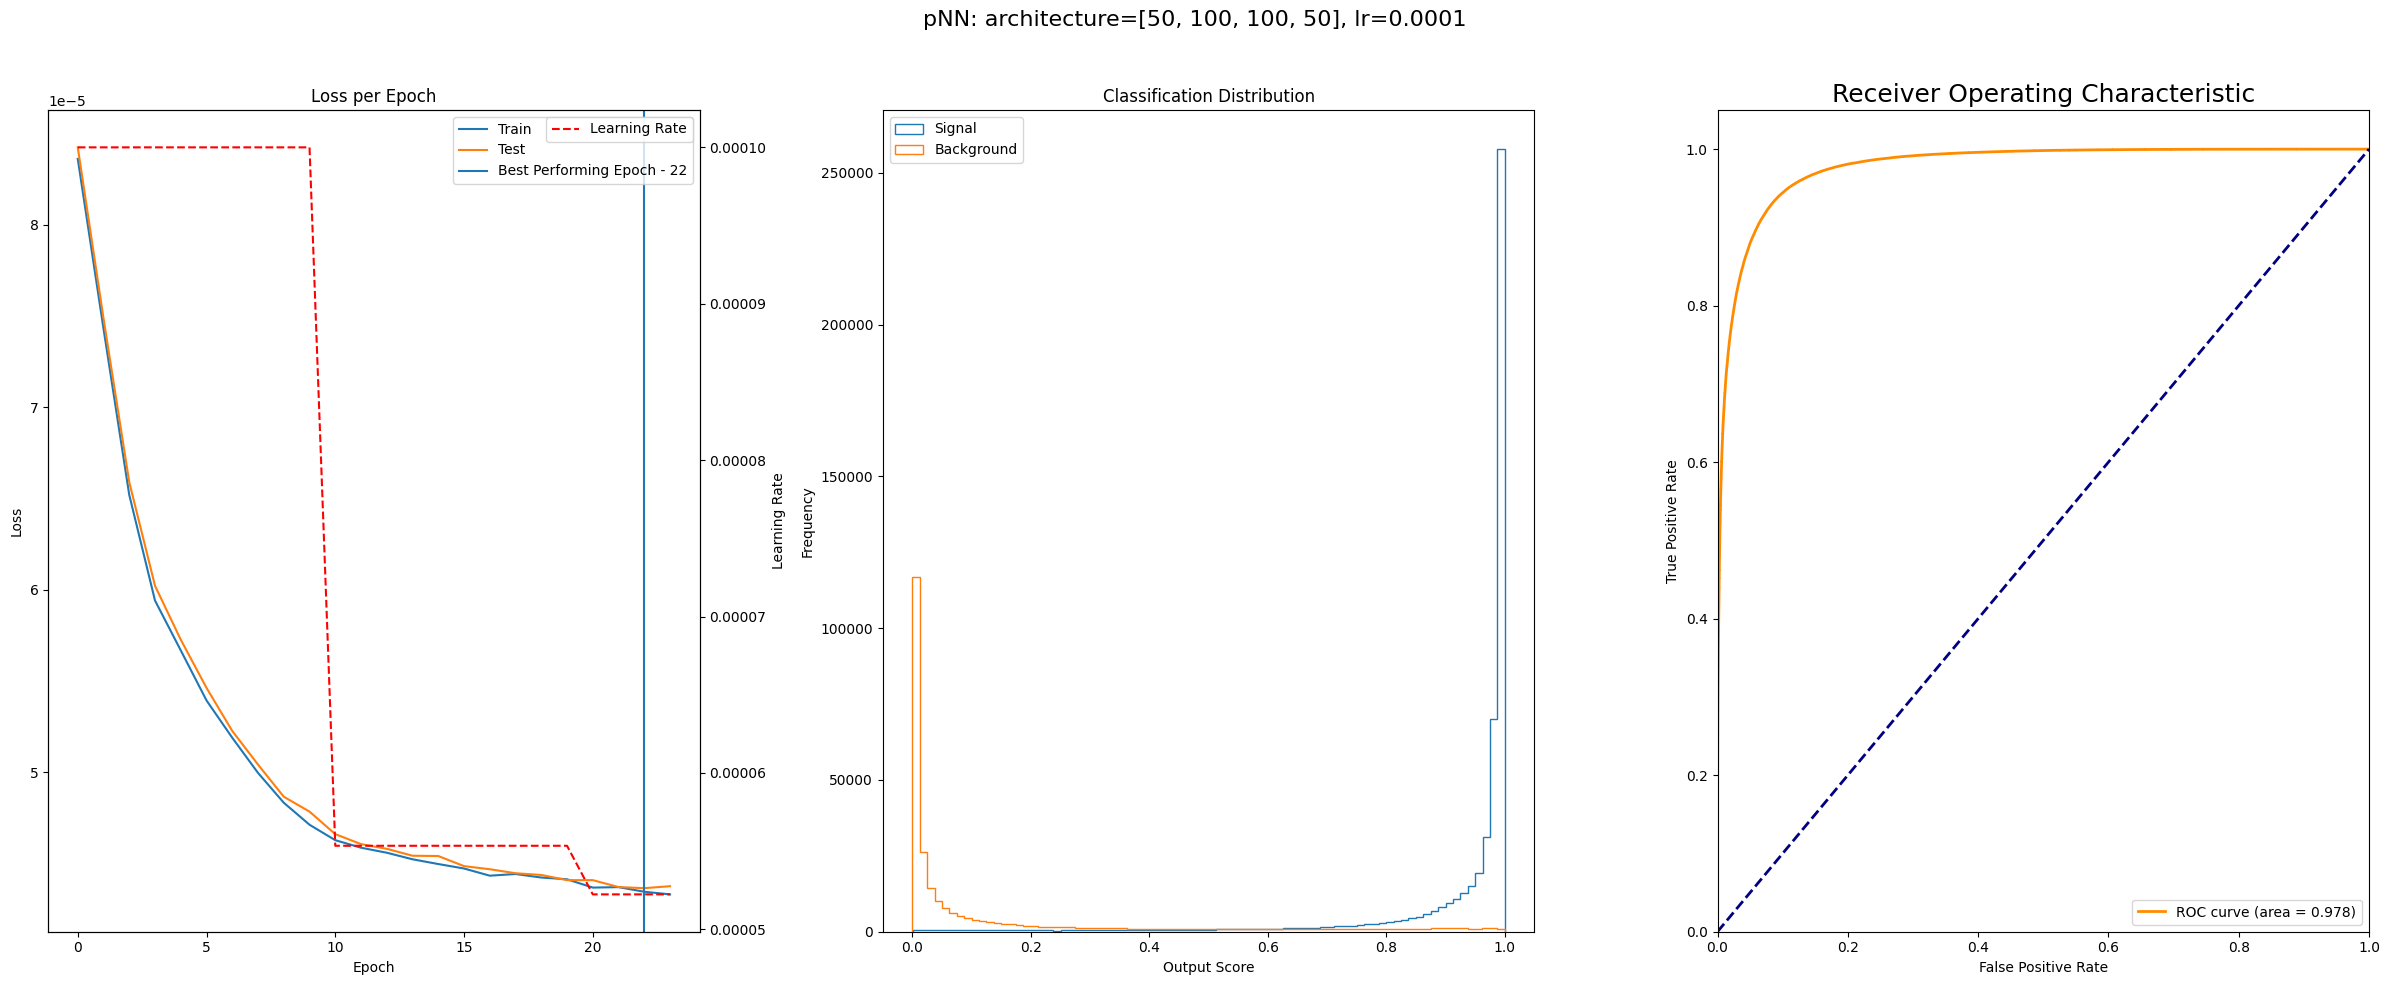

In [9]:
# Update this variable
plot_learning_rate = 'yes'

# You don't have to change anything below.
def separate_output_score(output_score,y):
    dict_ = {'pred':output_score.cpu().detach().numpy().flatten(),'true':y}
    temp_df = pd.DataFrame(dict_)
    signal_output_score = temp_df.loc[temp_df['true'] == 1]['pred']
    background_output_score = temp_df.loc[temp_df['true'] == 0]['pred']
    return signal_output_score,background_output_score

plot_learning_rate = 'yes'

signal_output_score,background_output_score = separate_output_score(output_score,x_test['y'])

    
fpr, tpr, thresholds = roc_curve(x_test['y'], output_score.cpu().detach().numpy())
roc_auc = auc(fpr, tpr)

fig, axs = plt.subplots(1, 3, figsize=(24, 10))
    
axs[0].plot(epoch_loss_train, label = 'Train')
axs[0].plot(epoch_loss_test, label = 'Test')
axs[0].axvline(best_epoch, label = f'Best Performing Epoch - {best_epoch}')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Loss per Epoch')
if plot_learning_rate == 'yes':
    ax1_twin = axs[0].twinx()
    ax1_twin.plot(learning_rate_epochs, label='Learning Rate', linestyle='--', color='red')
    ax1_twin.set_ylabel('Learning Rate')
    ax1_twin.tick_params(axis='y')
axs[0].legend(loc='upper right')

axs[1].hist(signal_output_score, label = 'Signal',bins=80,histtype='step')
axs[1].hist(background_output_score, label = 'Background',bins=80,histtype='step')
axs[1].set_xlabel("Output Score")
axs[1].set_title('Classification Distribution')
axs[1].set_ylabel("Frequency")
axs[1].legend()

axs[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
axs[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[2].set_xlim([0.0, 1.0])
axs[2].set_ylim([0.0, 1.05])
axs[2].set_xlabel('False Positive Rate')
axs[2].set_ylabel('True Positive Rate')
axs[2].set_title('Receiver Operating Characteristic',fontsize=18)
axs[2].legend(loc="lower right")
plt.tight_layout()
plt.legend()
#plt.title(f'{signal_names[l]}')
plt.savefig(f'{directory}/graph.pdf',format = 'pdf')
print(f">> {directory}/graph.pdf saved succesfully...")
fig.suptitle(f'pNN: architecture={nodes}, lr={learning_rate}', fontsize=16)
fig.subplots_adjust(top=0.88)
plt.savefig(f'{directory}/graph.png',format = 'png')
print(f">> {directory}/graph.png saved succesfully...")
plt.show()

## Step 2: Testing Individual Signals using the pNN.

>> All graphs and output score data will be saved in: models_27_features_[50, 100, 100, 50]_test ...
>> Saved output score in: output_score_signal_260.pkl ...


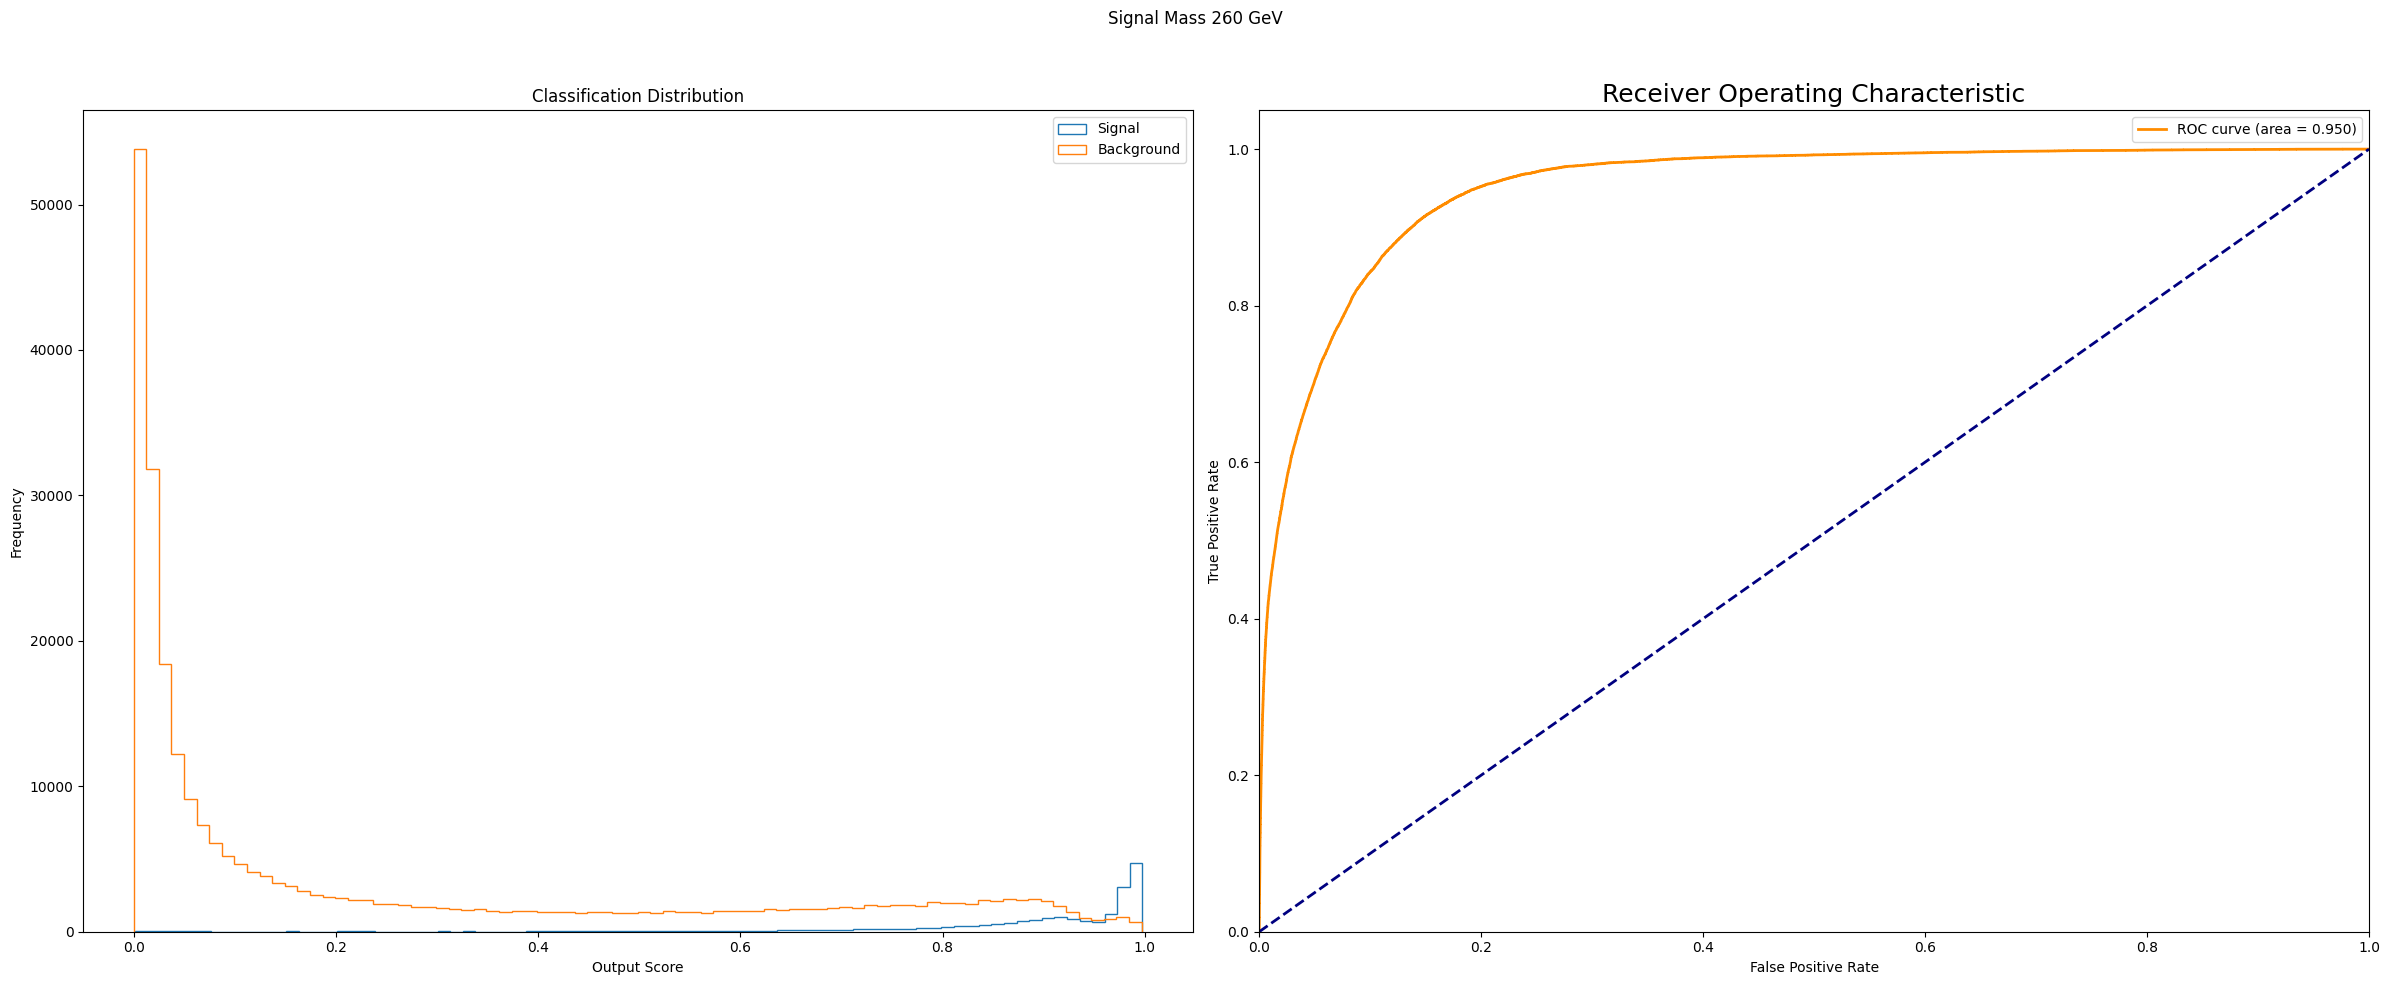

>> Saved output score in: output_score_signal_270.pkl ...


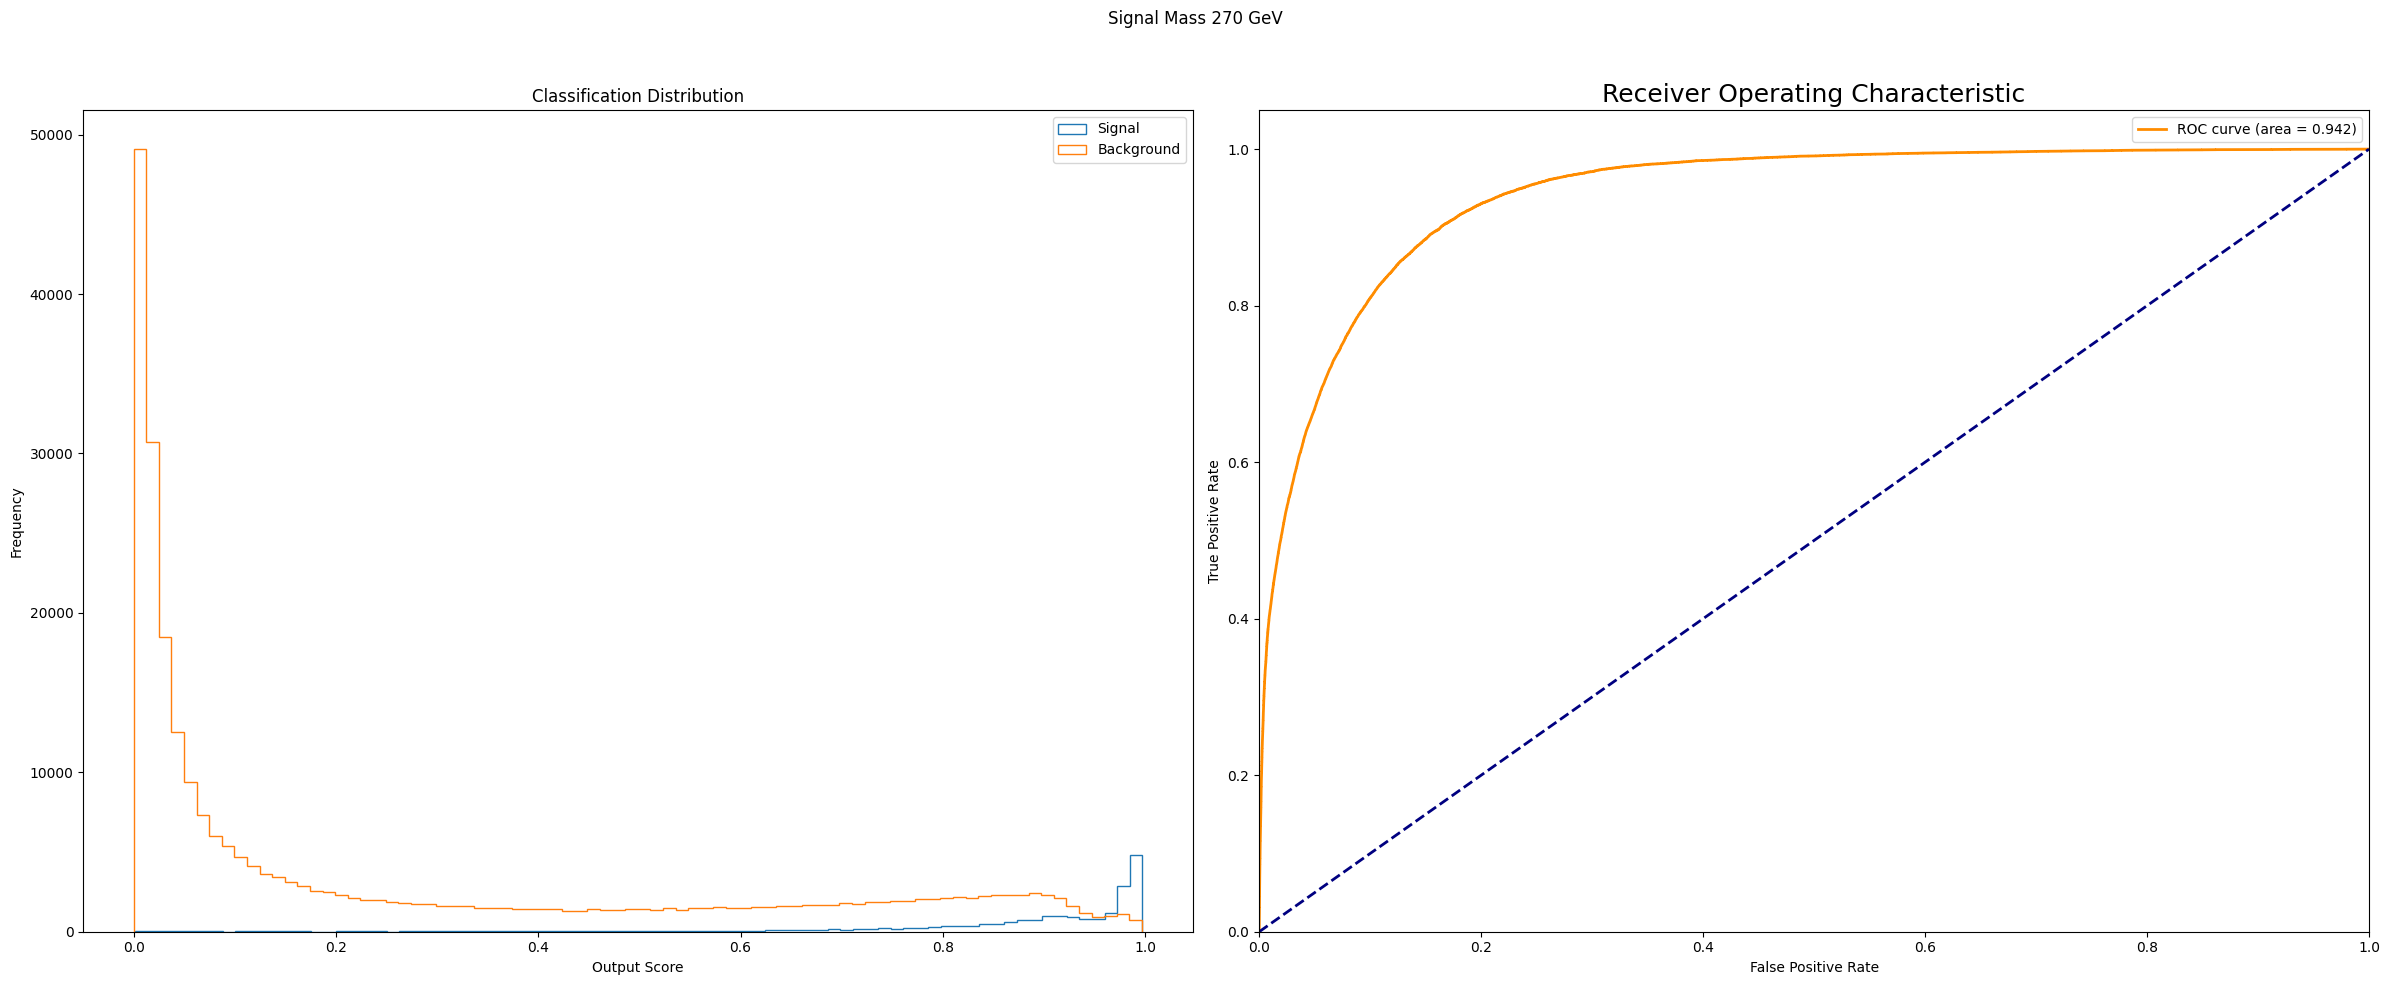

>> Saved output score in: output_score_signal_280.pkl ...


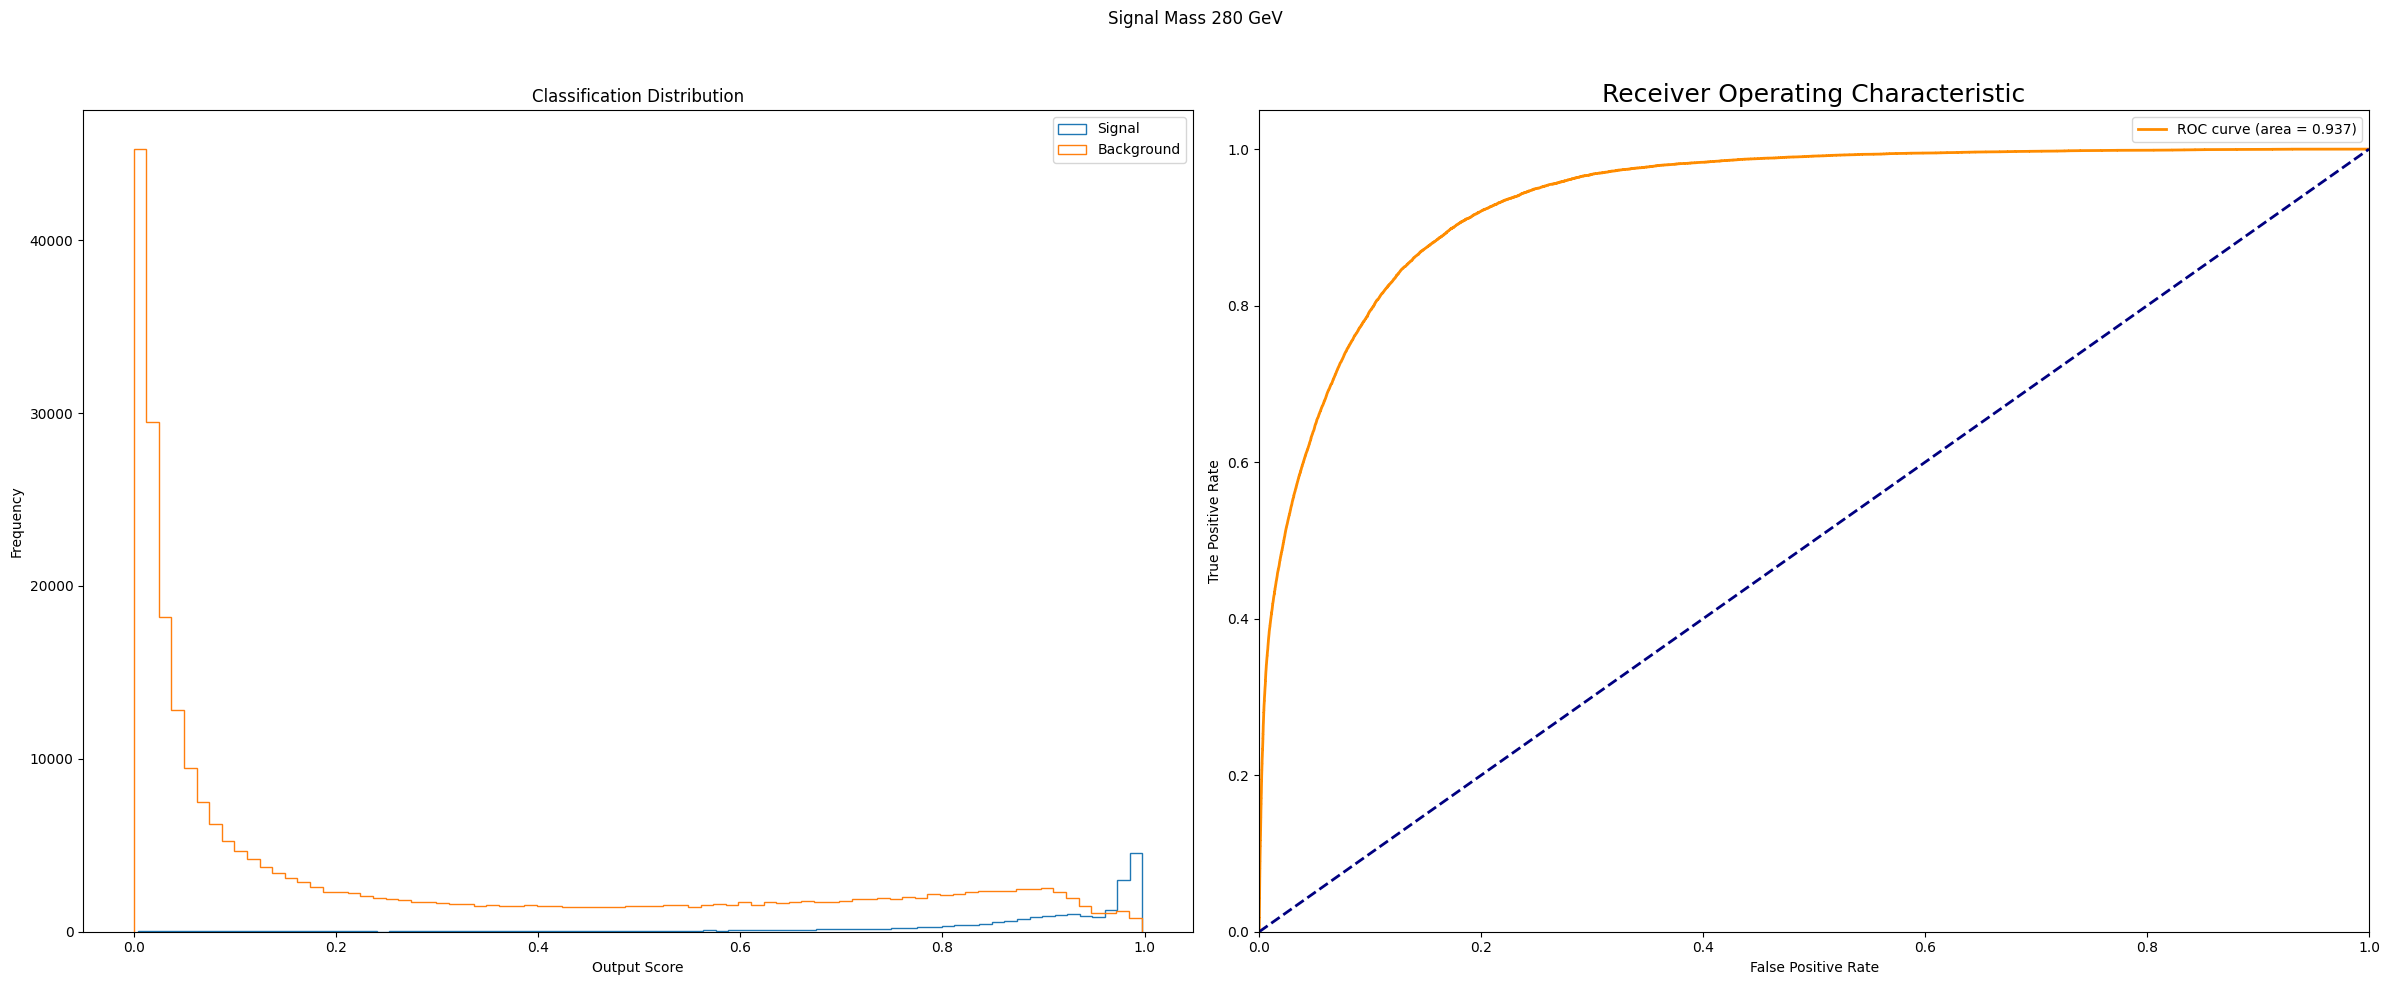

>> Saved output score in: output_score_signal_290.pkl ...


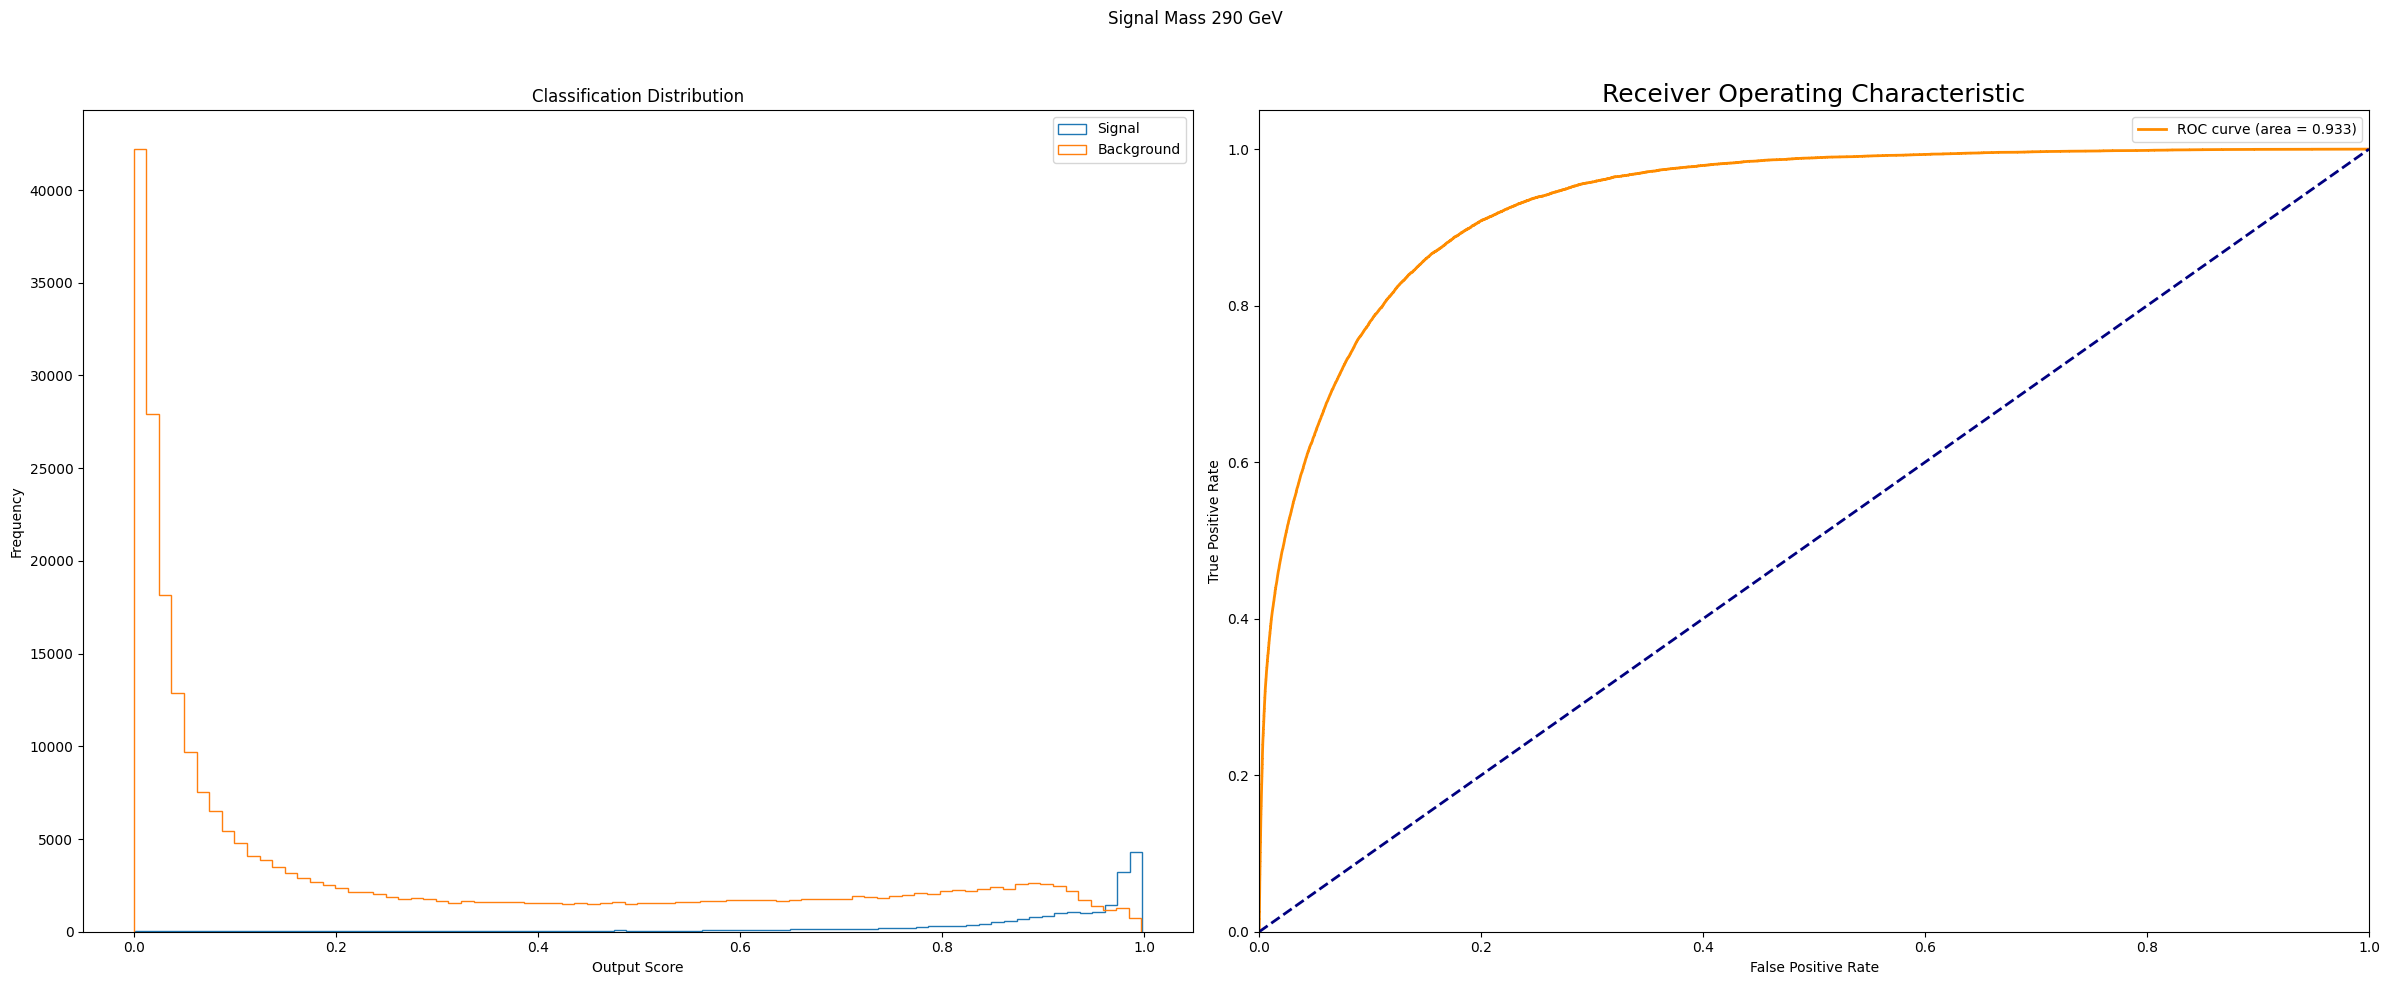

>> Saved output score in: output_score_signal_300.pkl ...


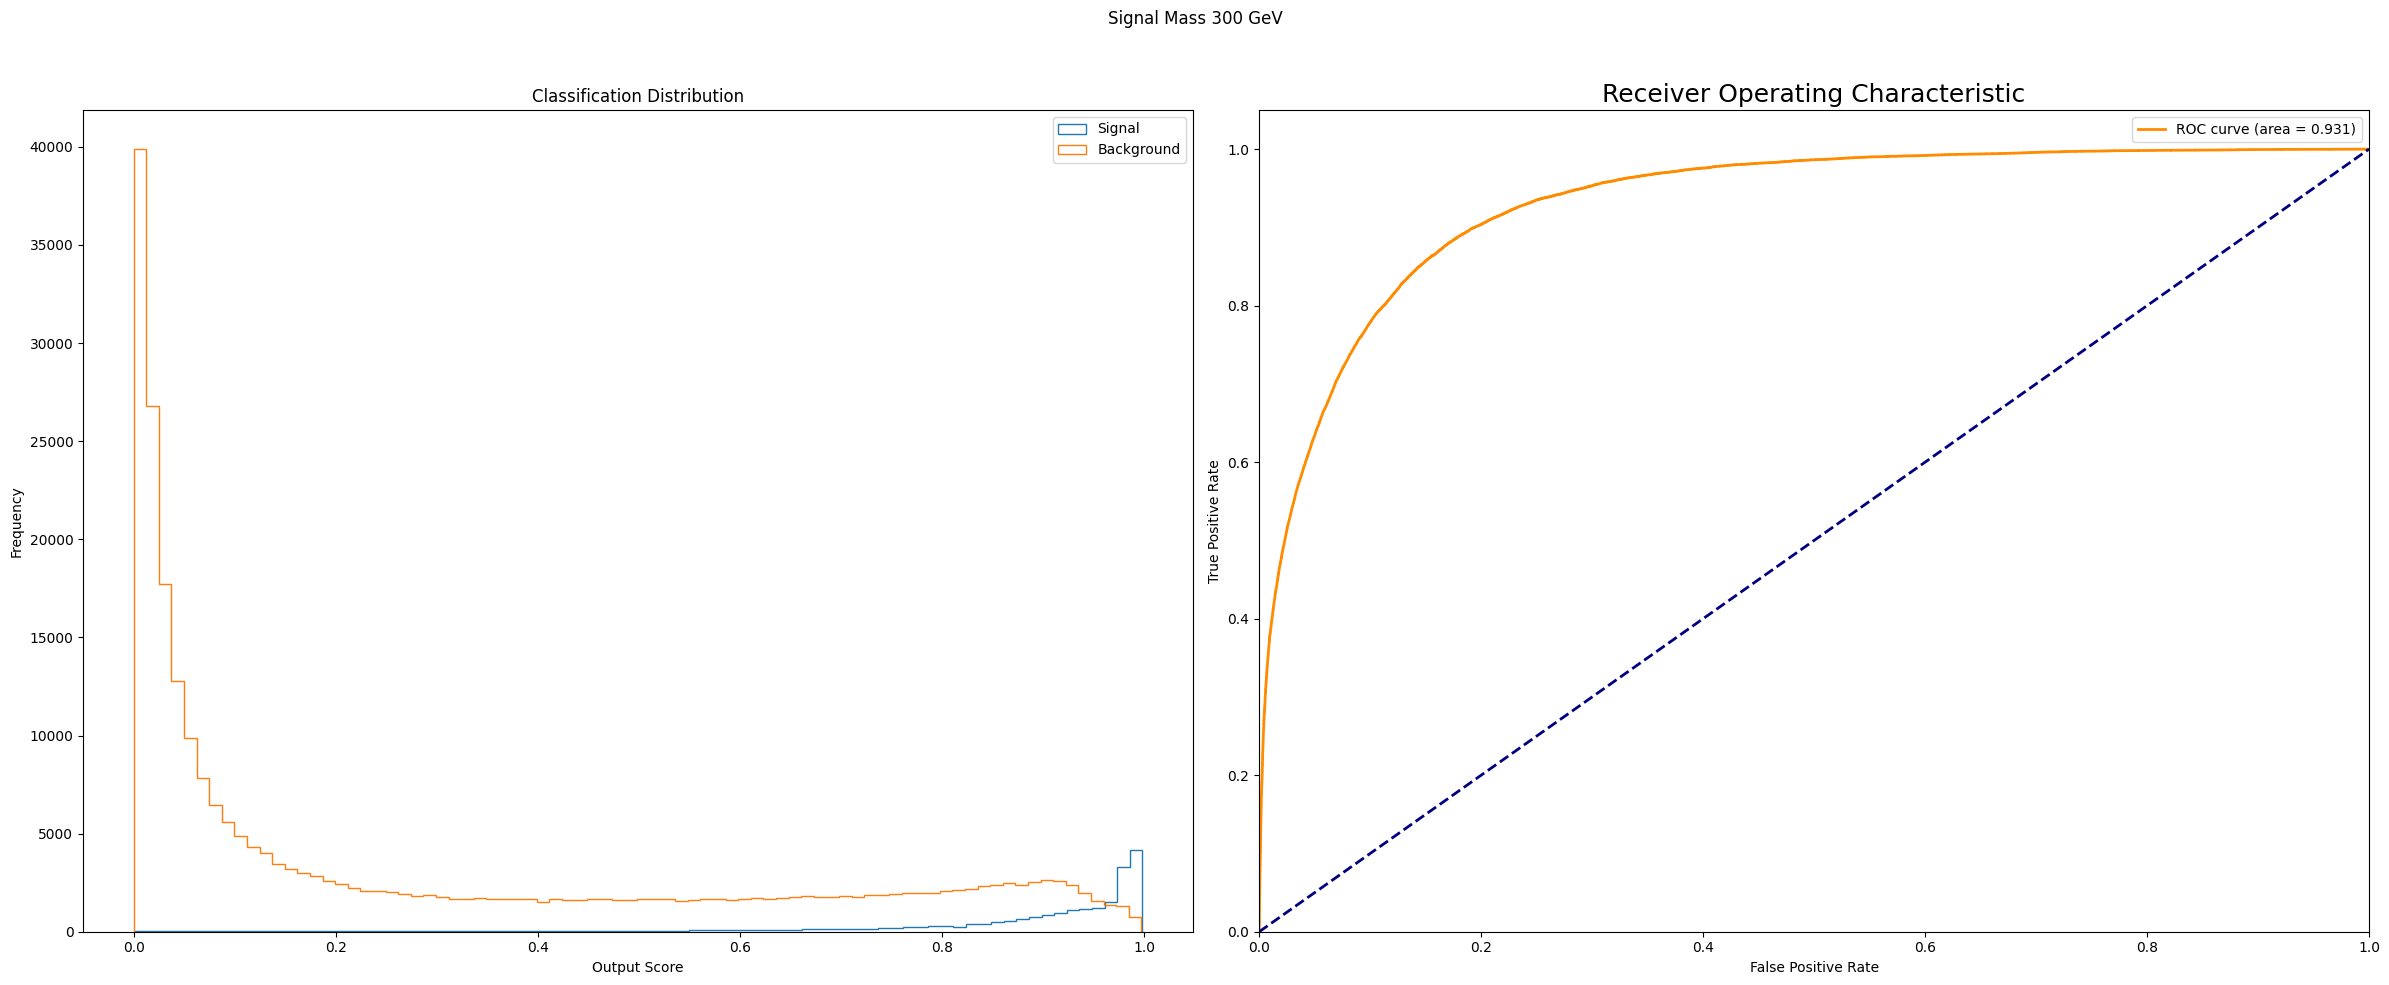

>> Saved output score in: output_score_signal_320.pkl ...


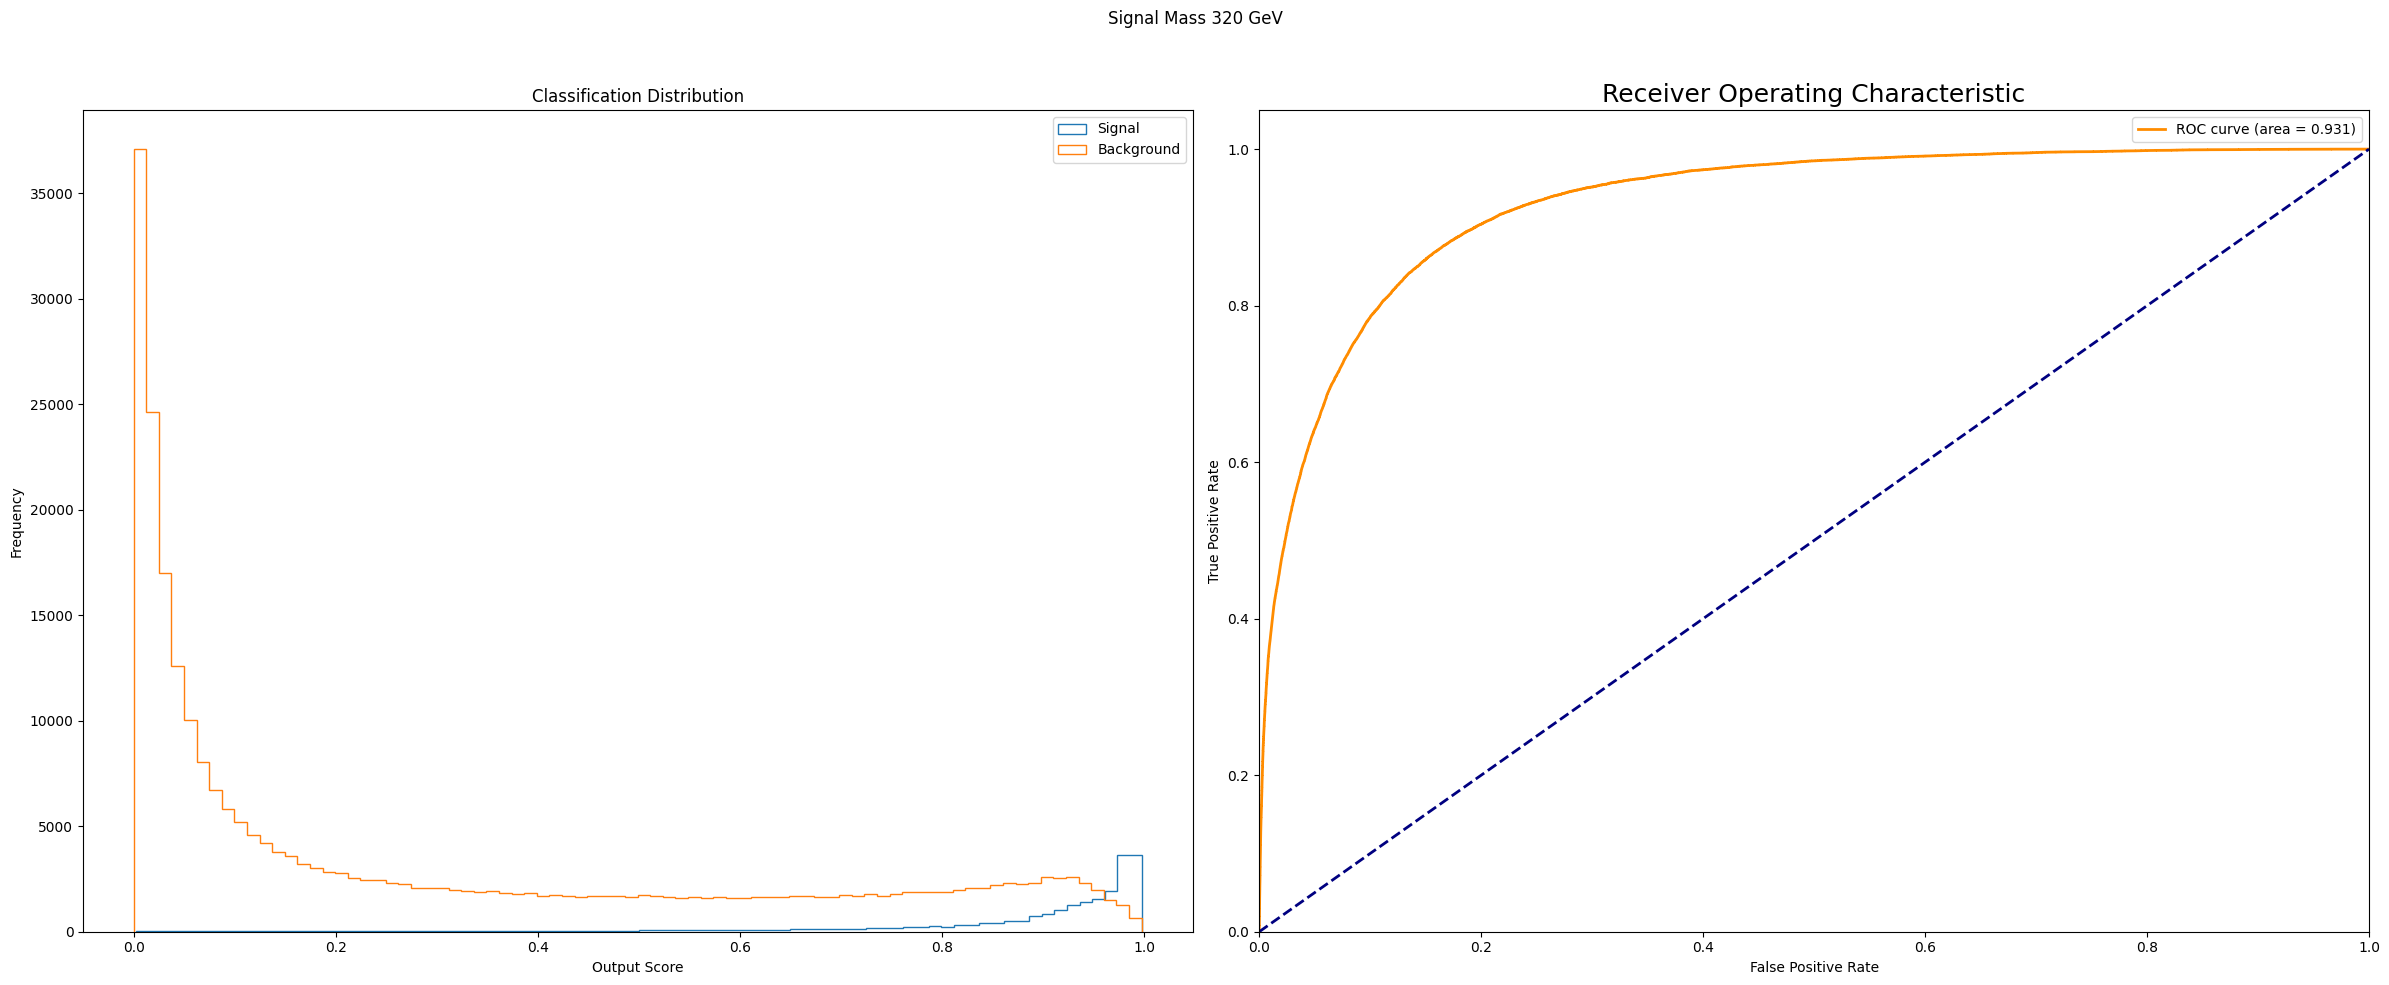

>> Saved output score in: output_score_signal_350.pkl ...


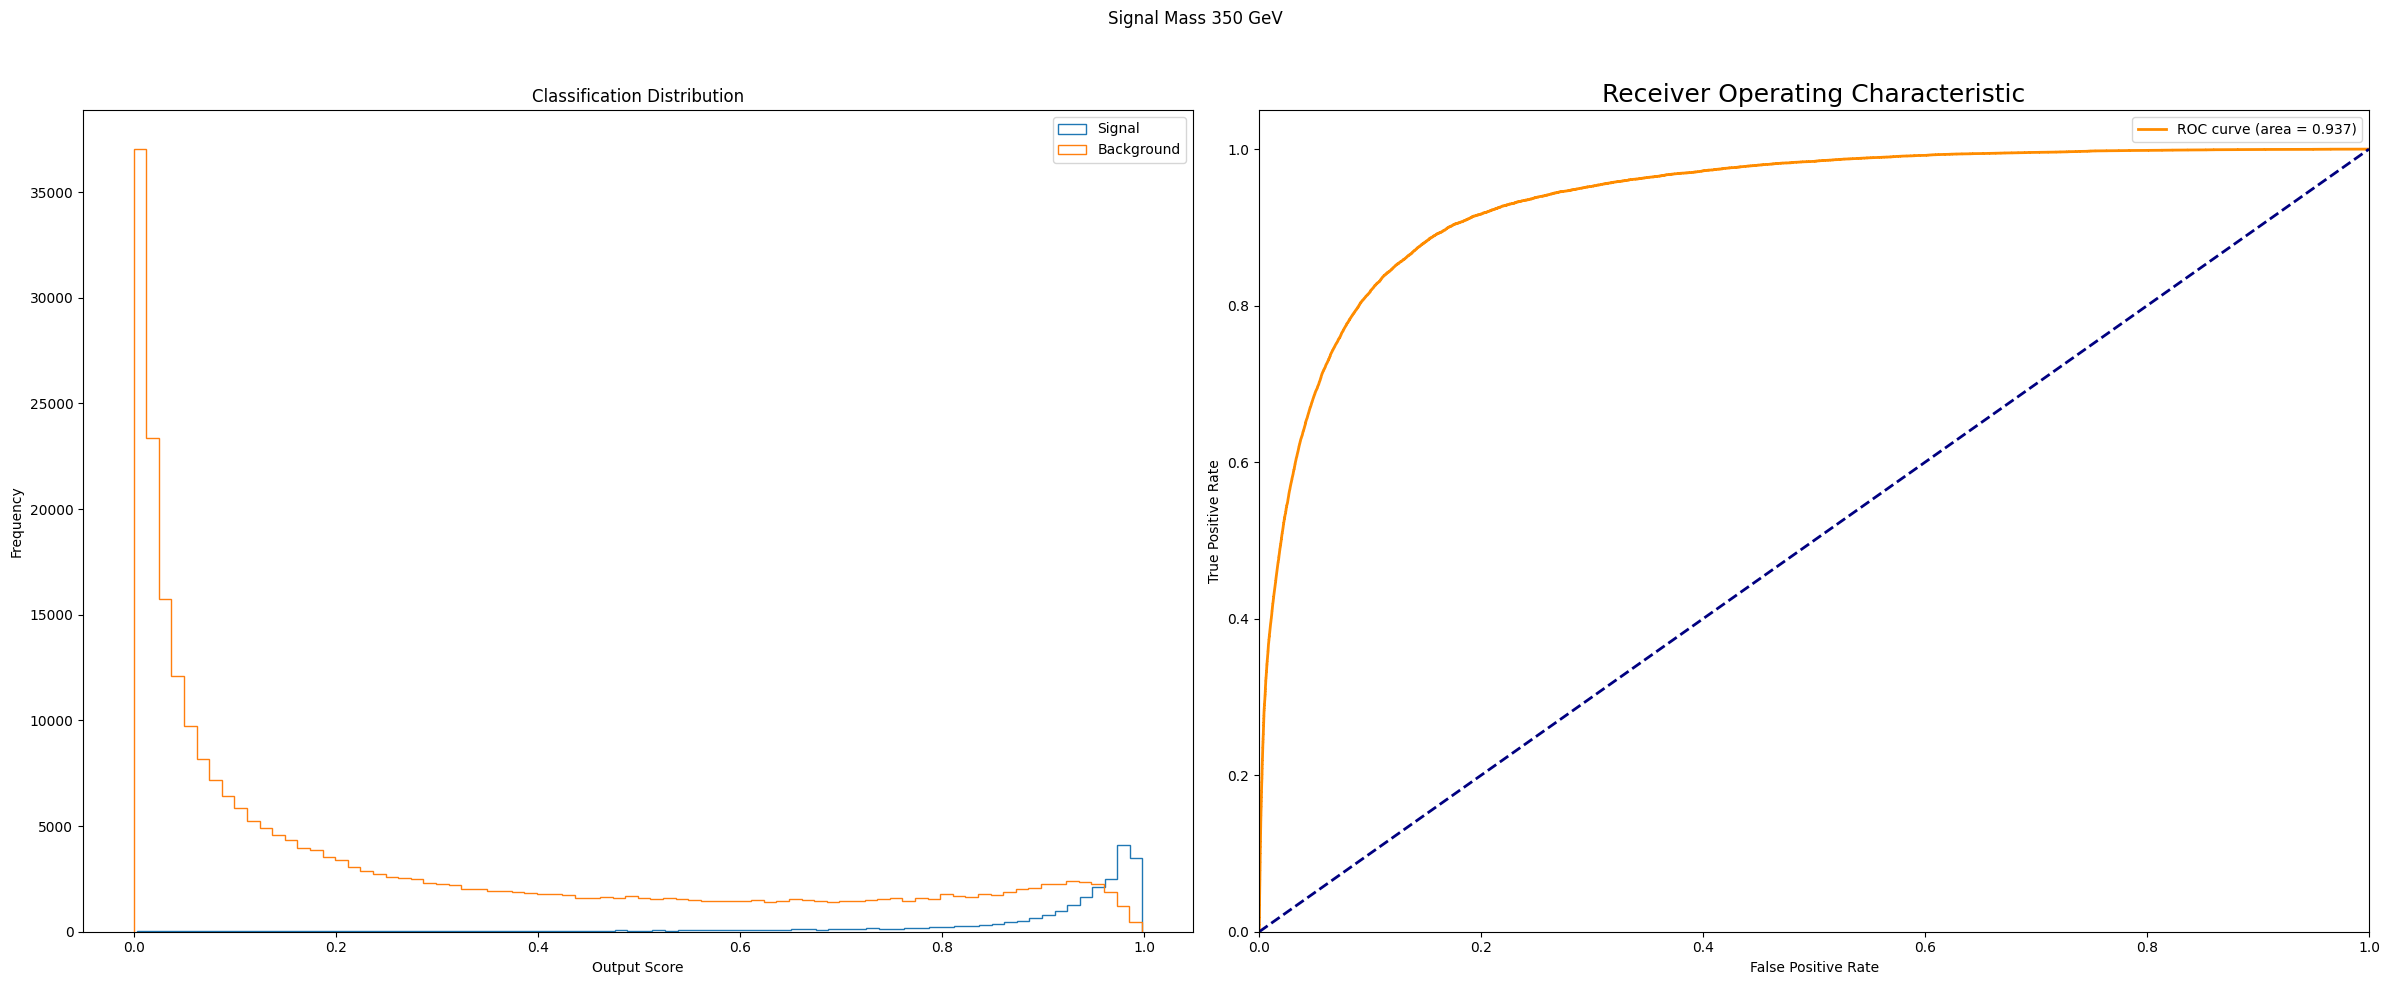

>> Saved output score in: output_score_signal_400.pkl ...


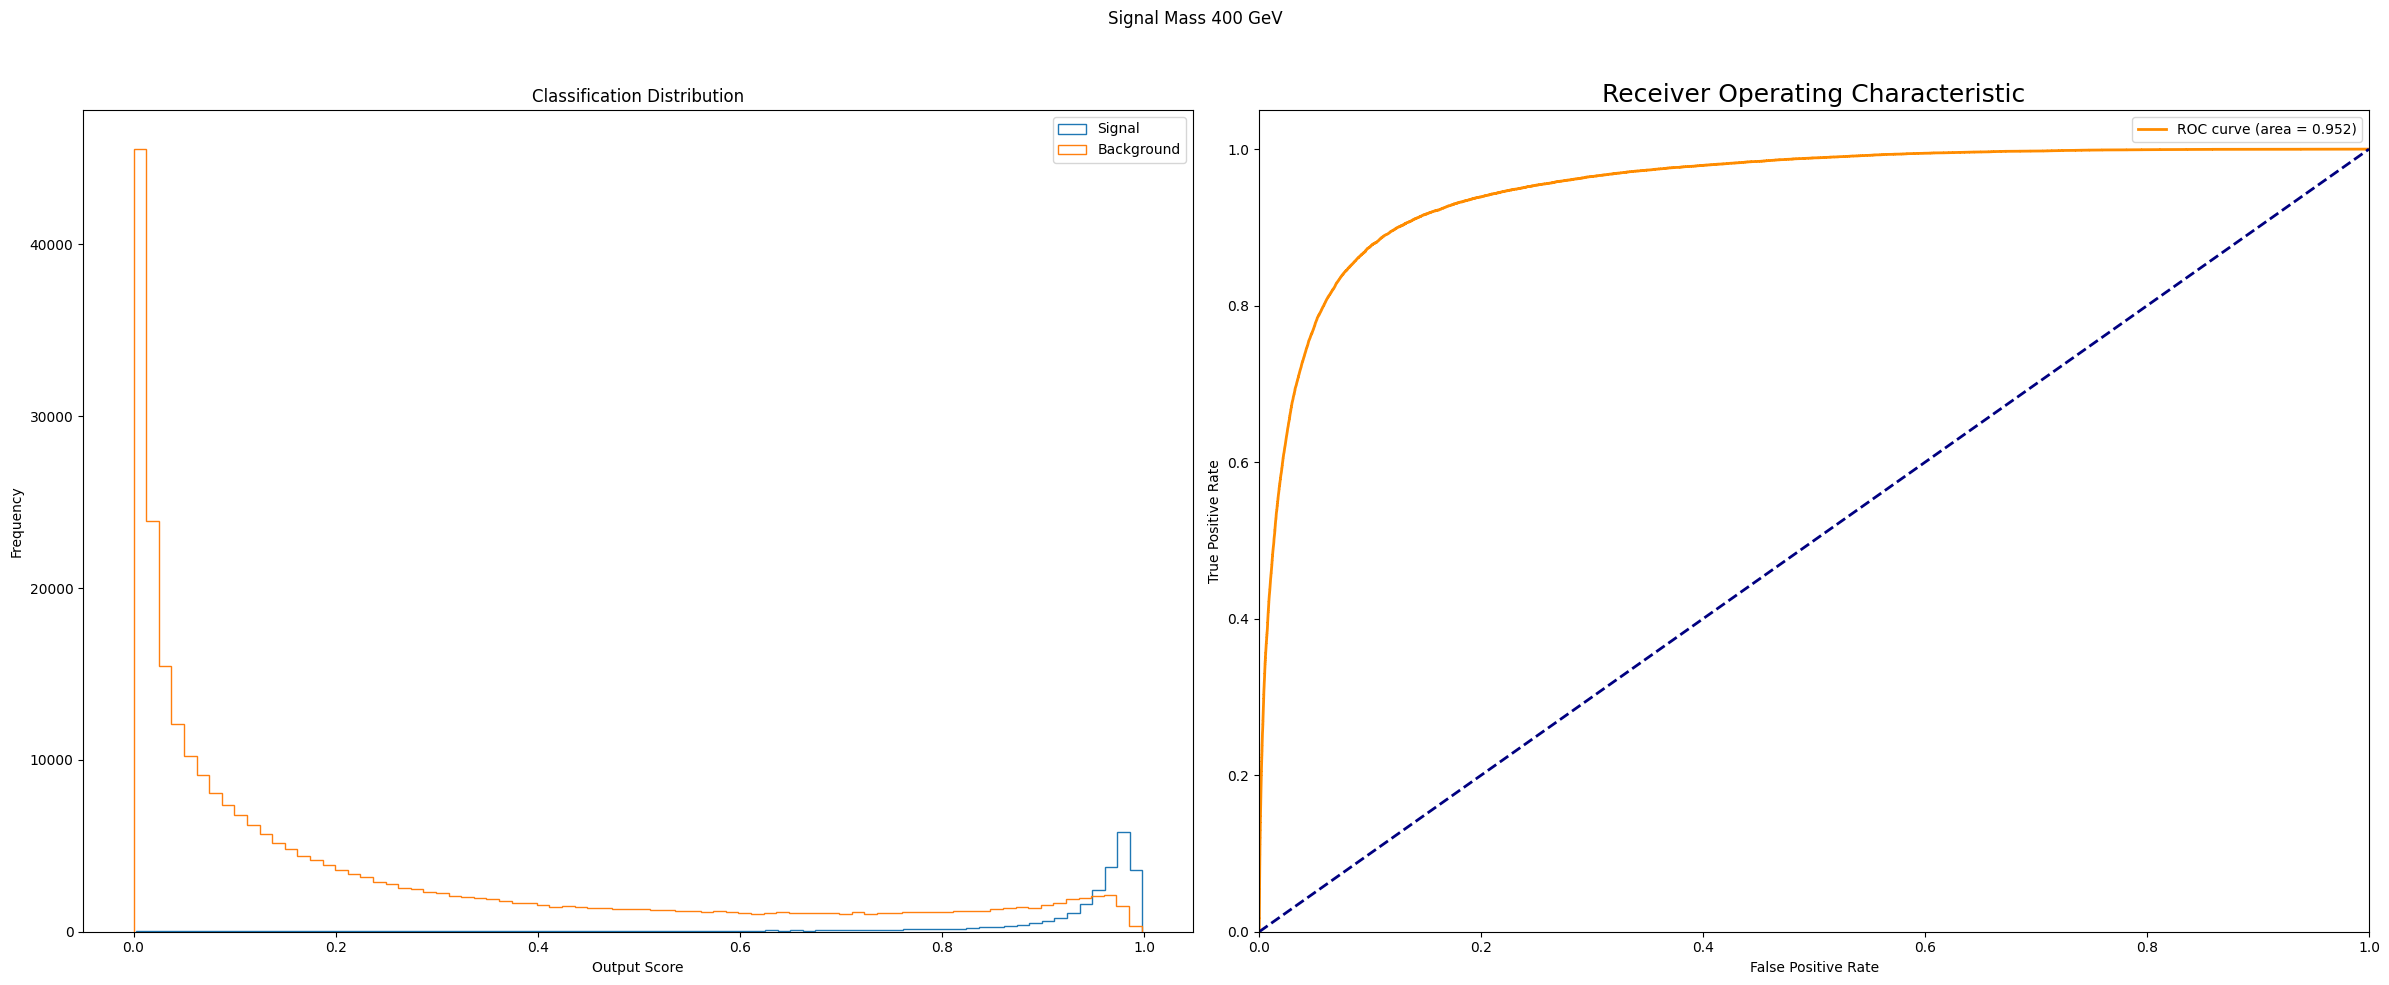

>> Saved output score in: output_score_signal_450.pkl ...


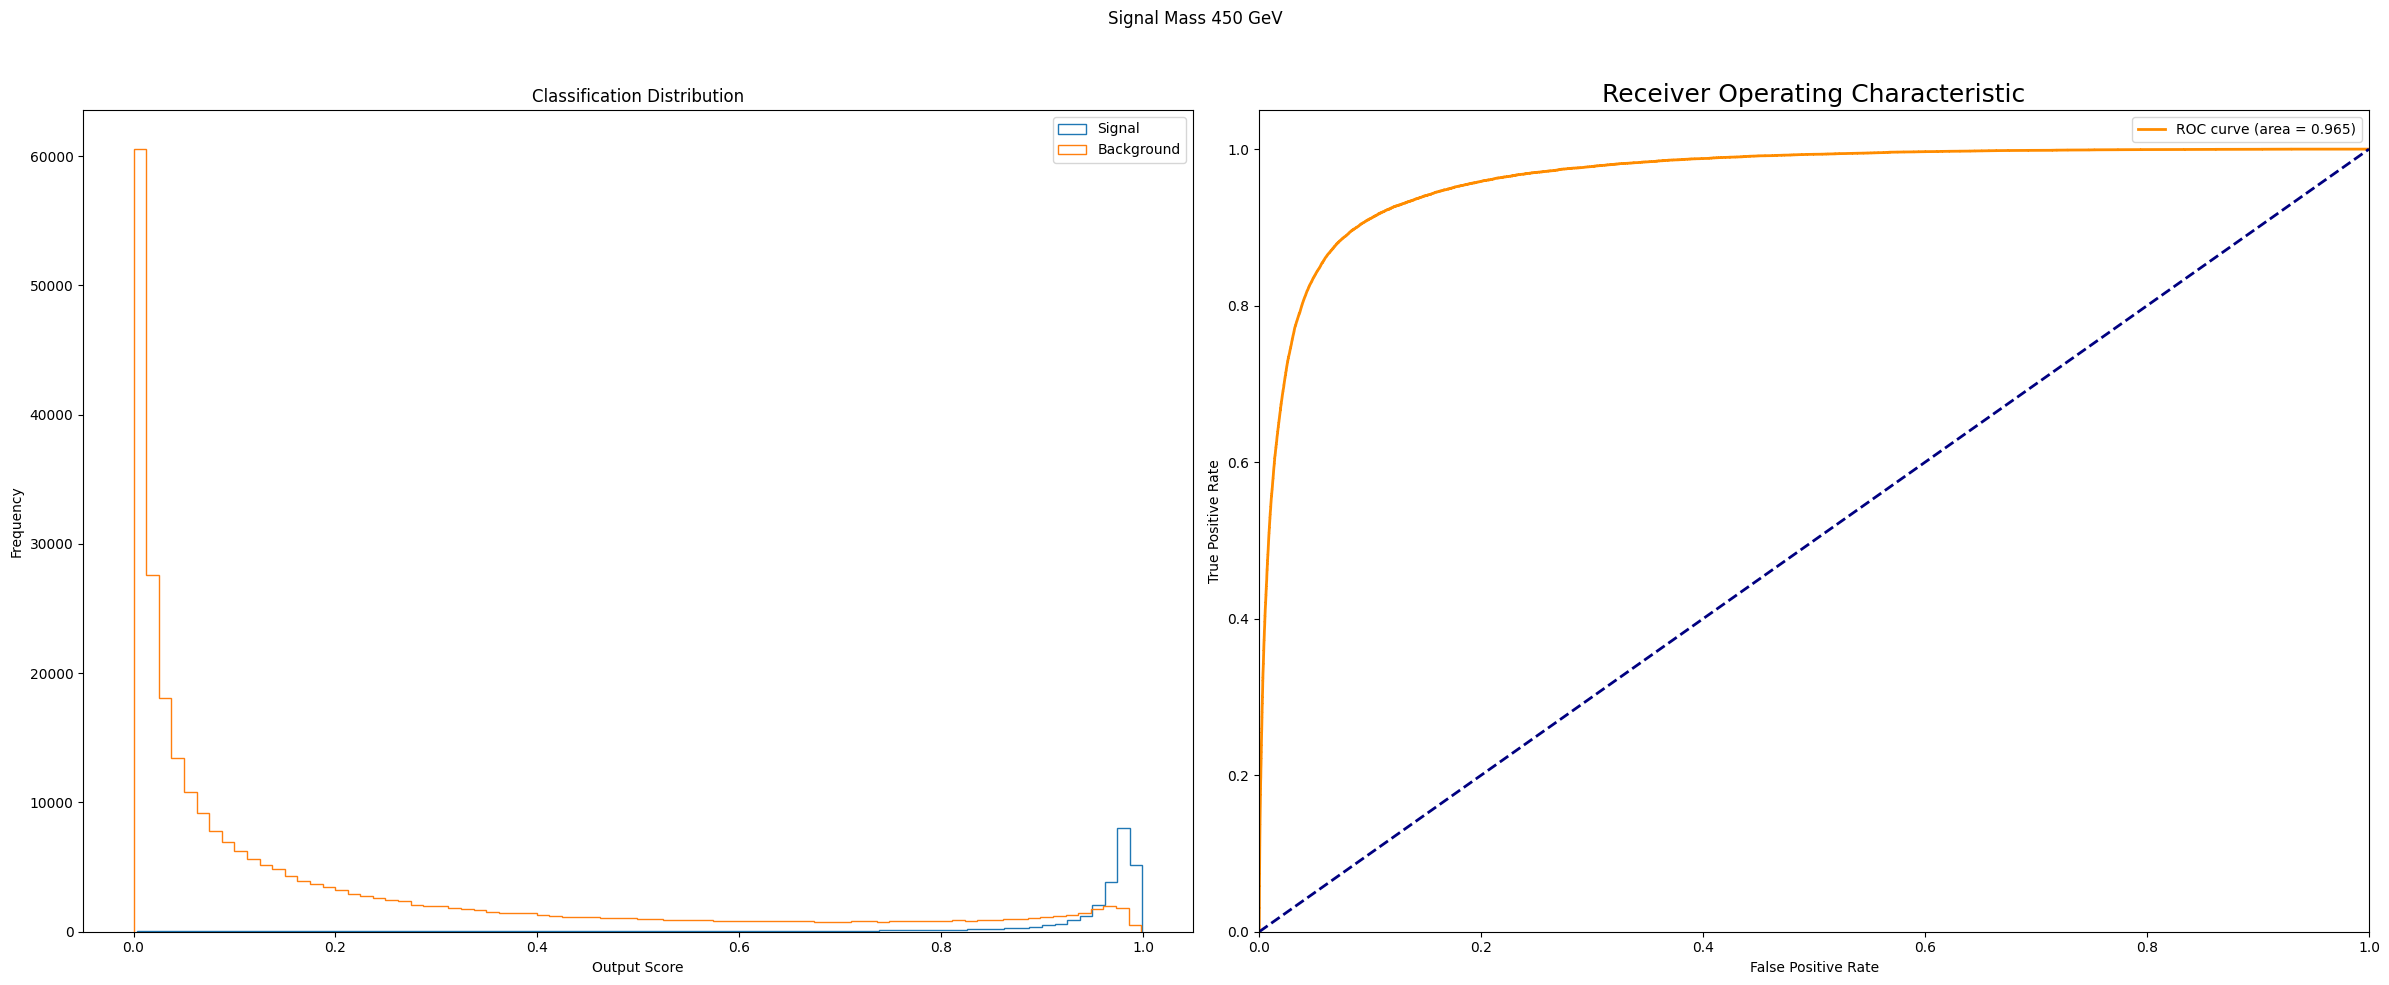

>> Saved output score in: output_score_signal_500.pkl ...


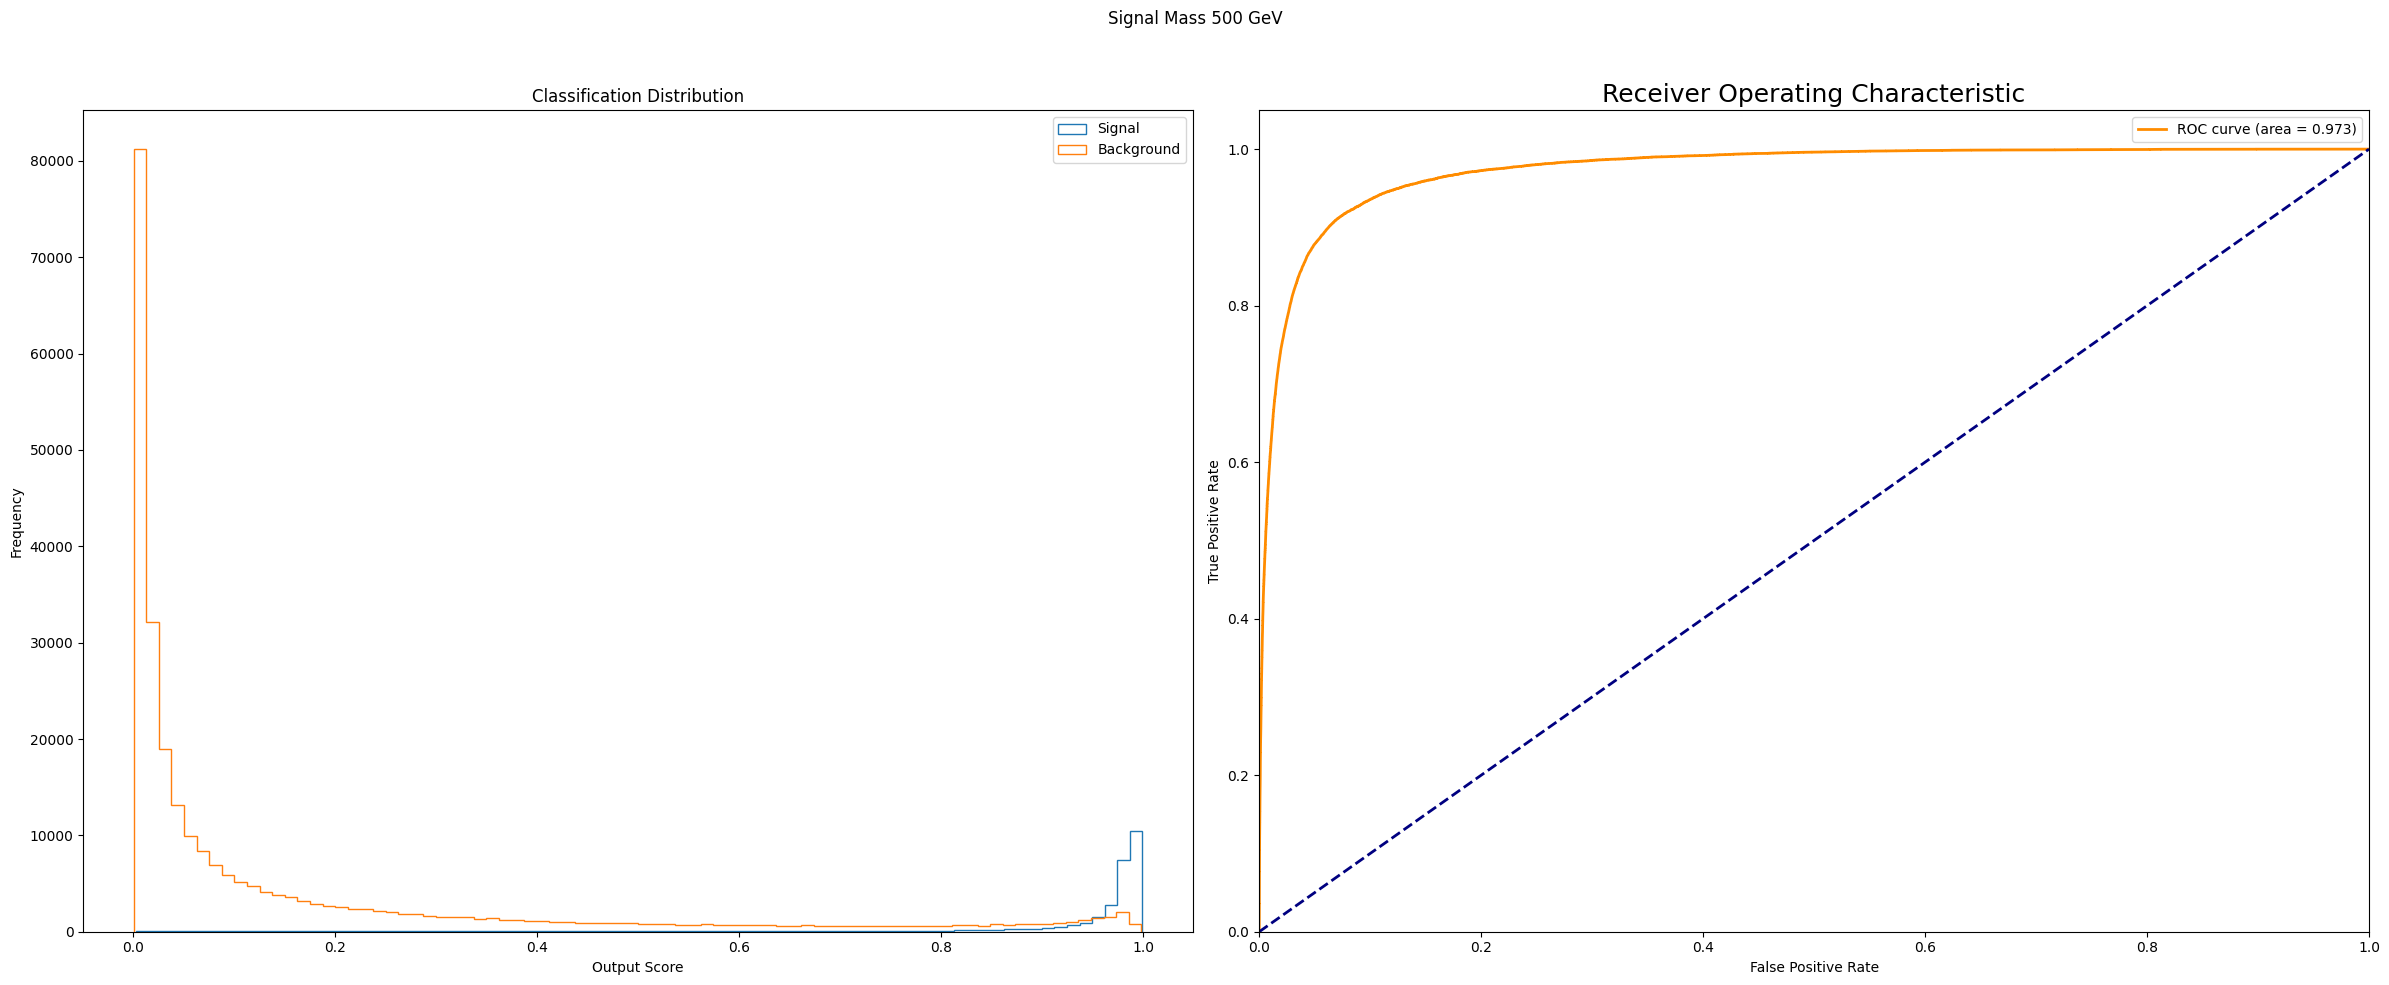

>> Saved output score in: output_score_signal_550.pkl ...


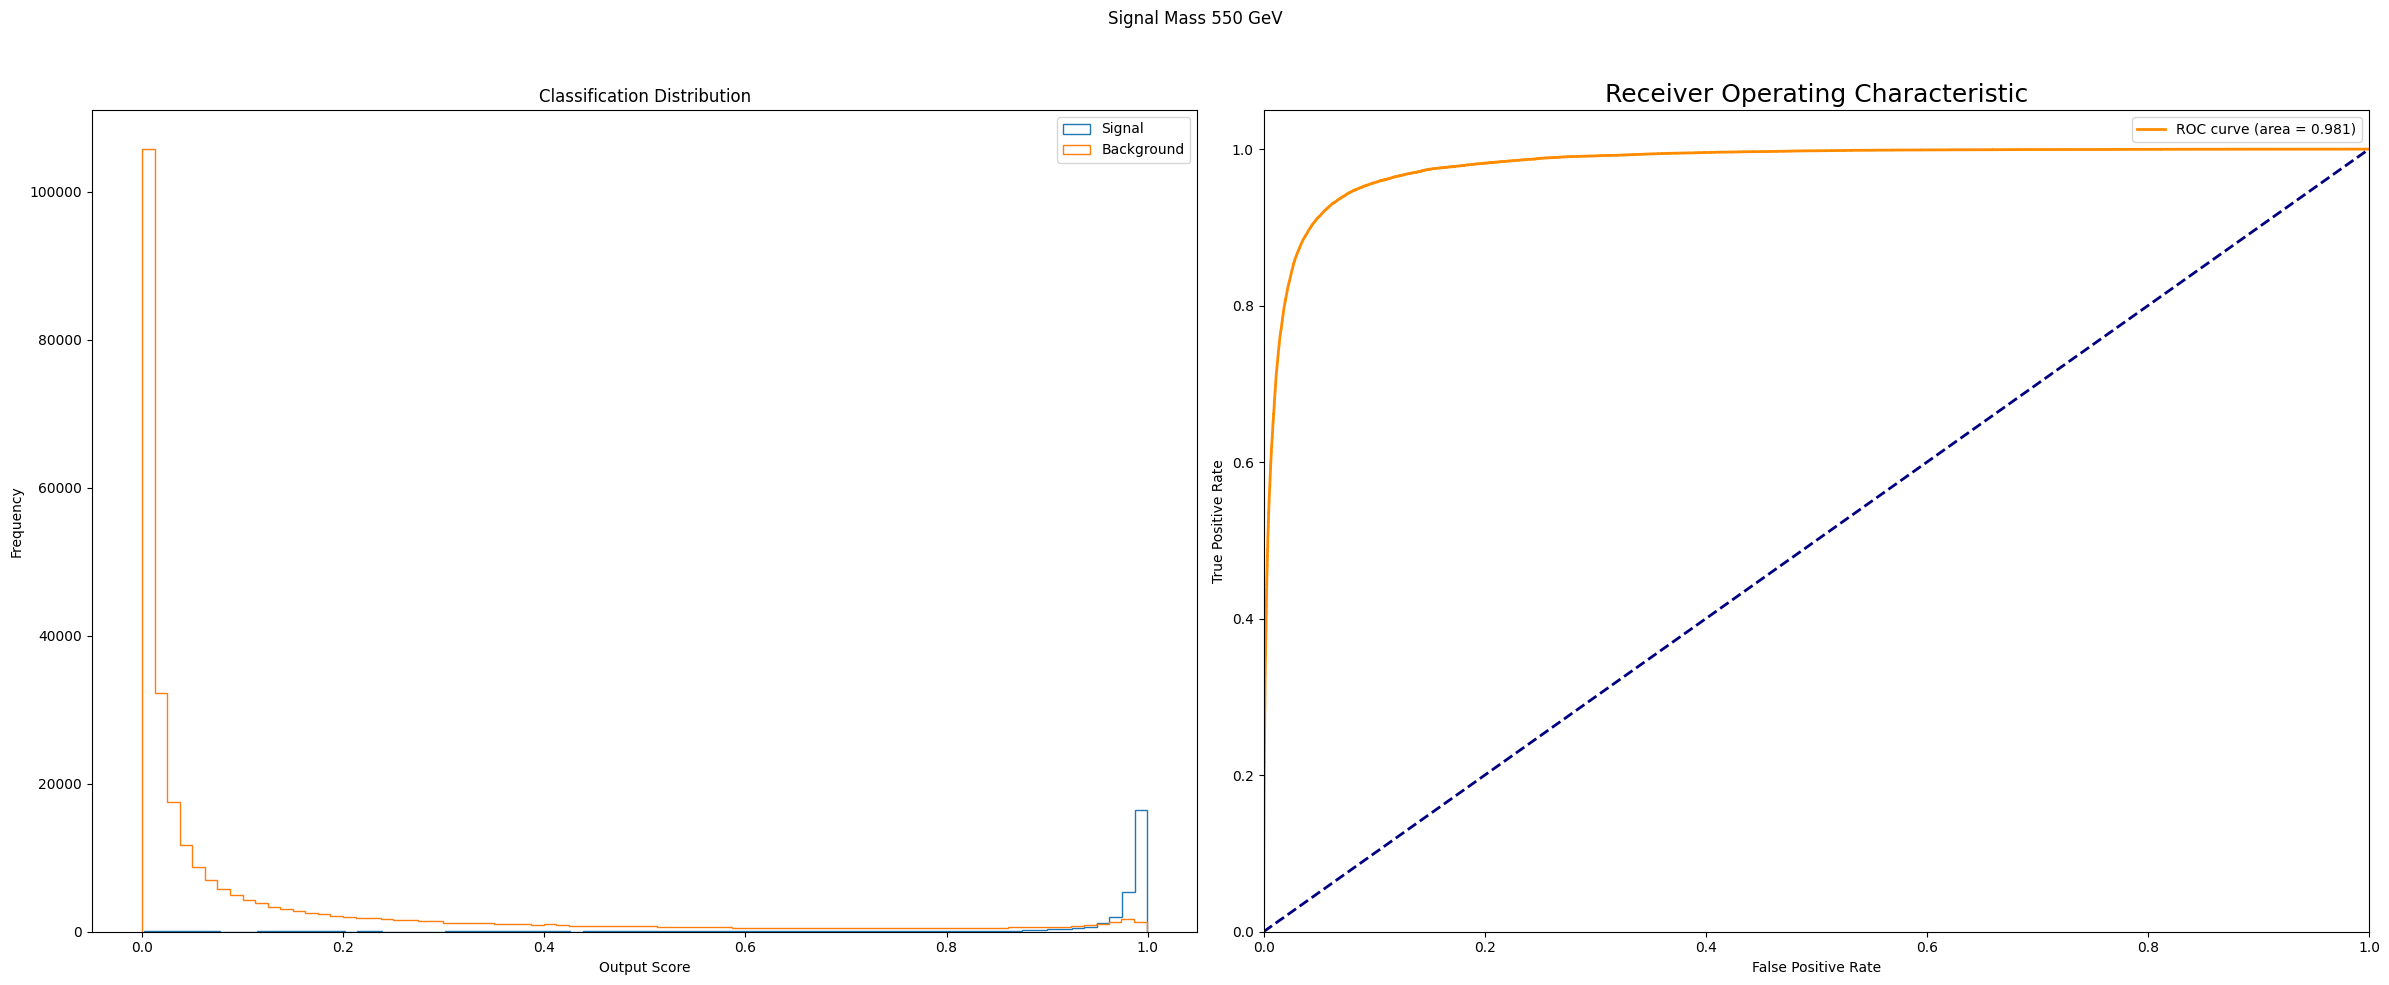

>> Saved output score in: output_score_signal_600.pkl ...


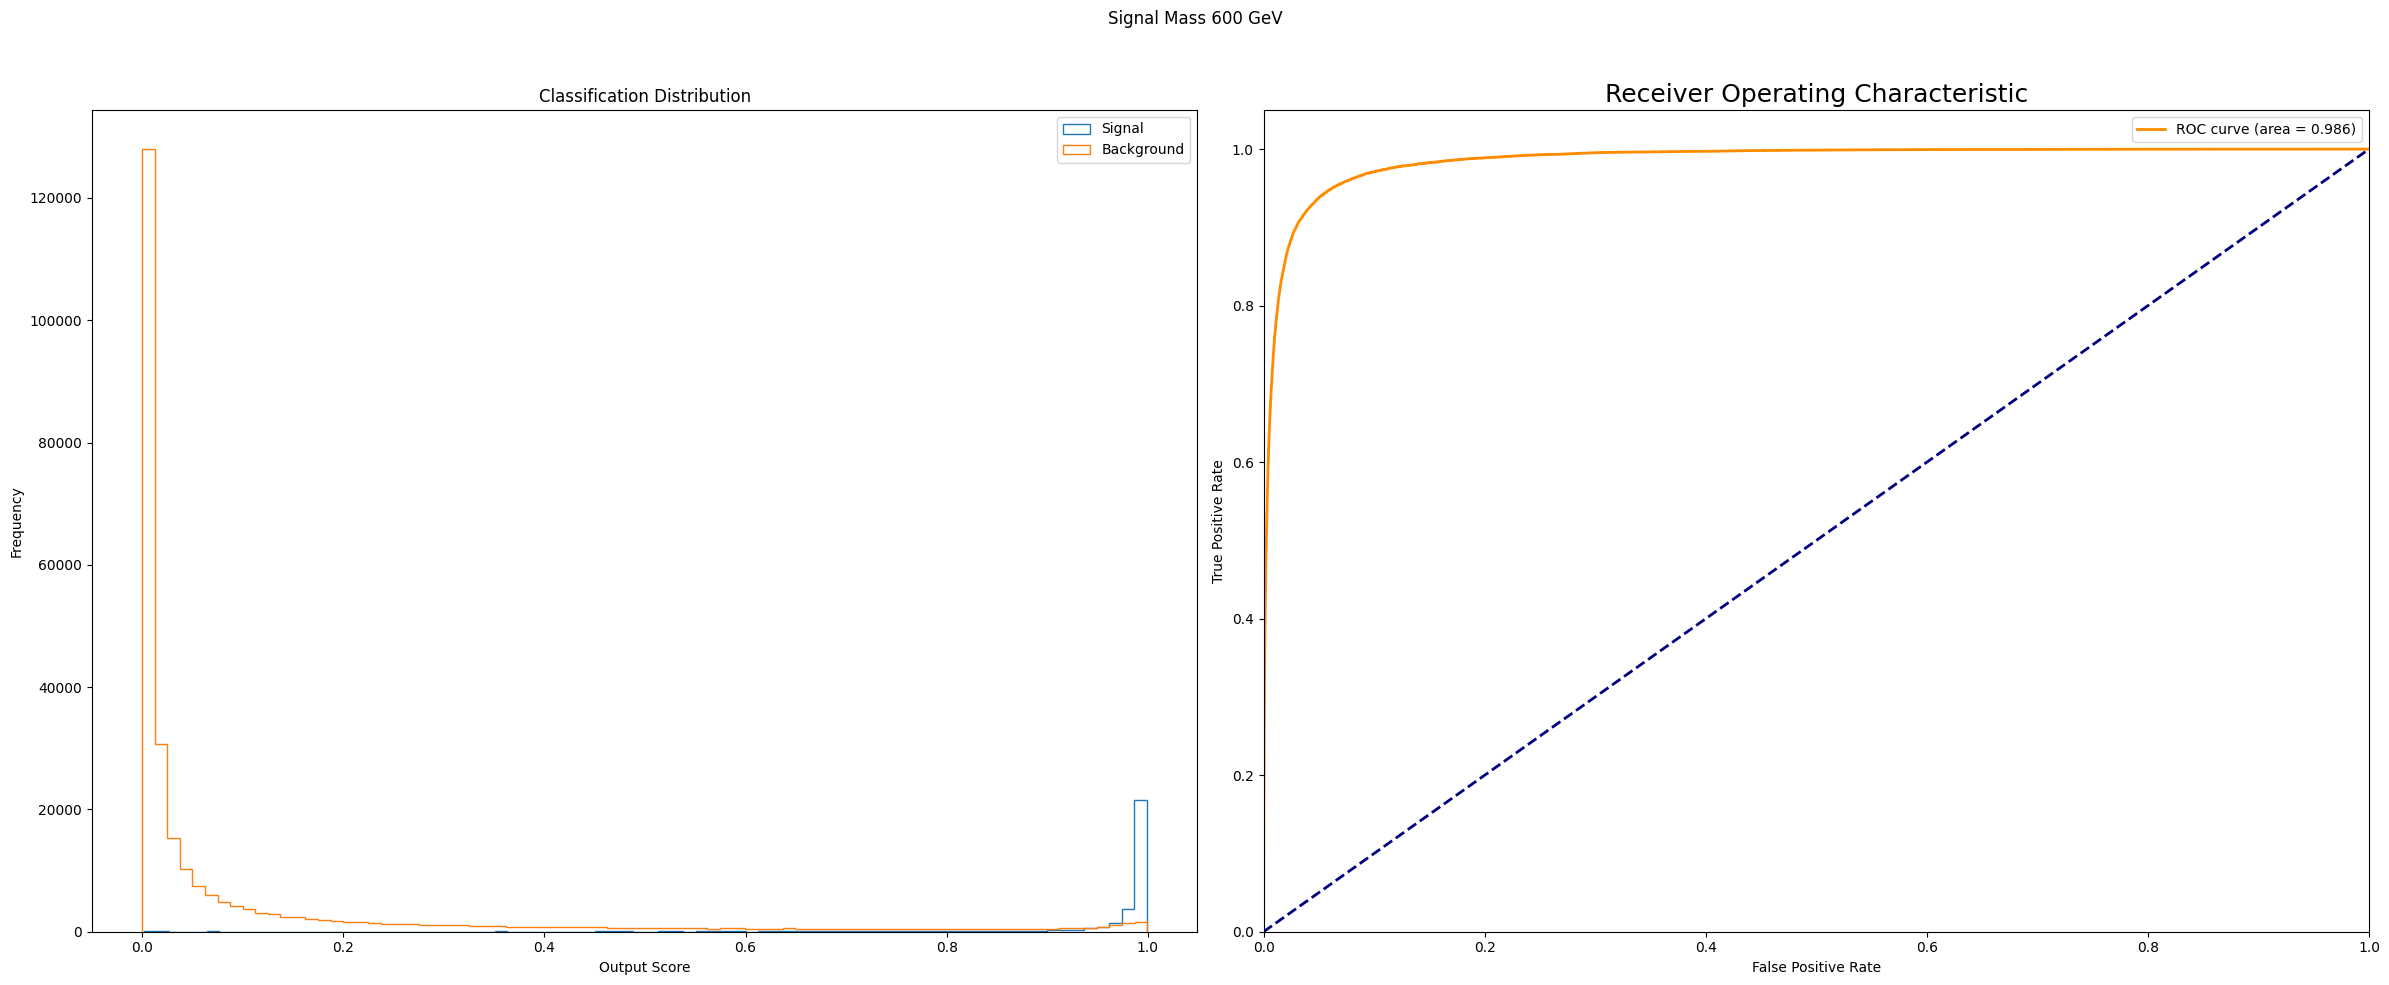

>> Saved output score in: output_score_signal_650.pkl ...


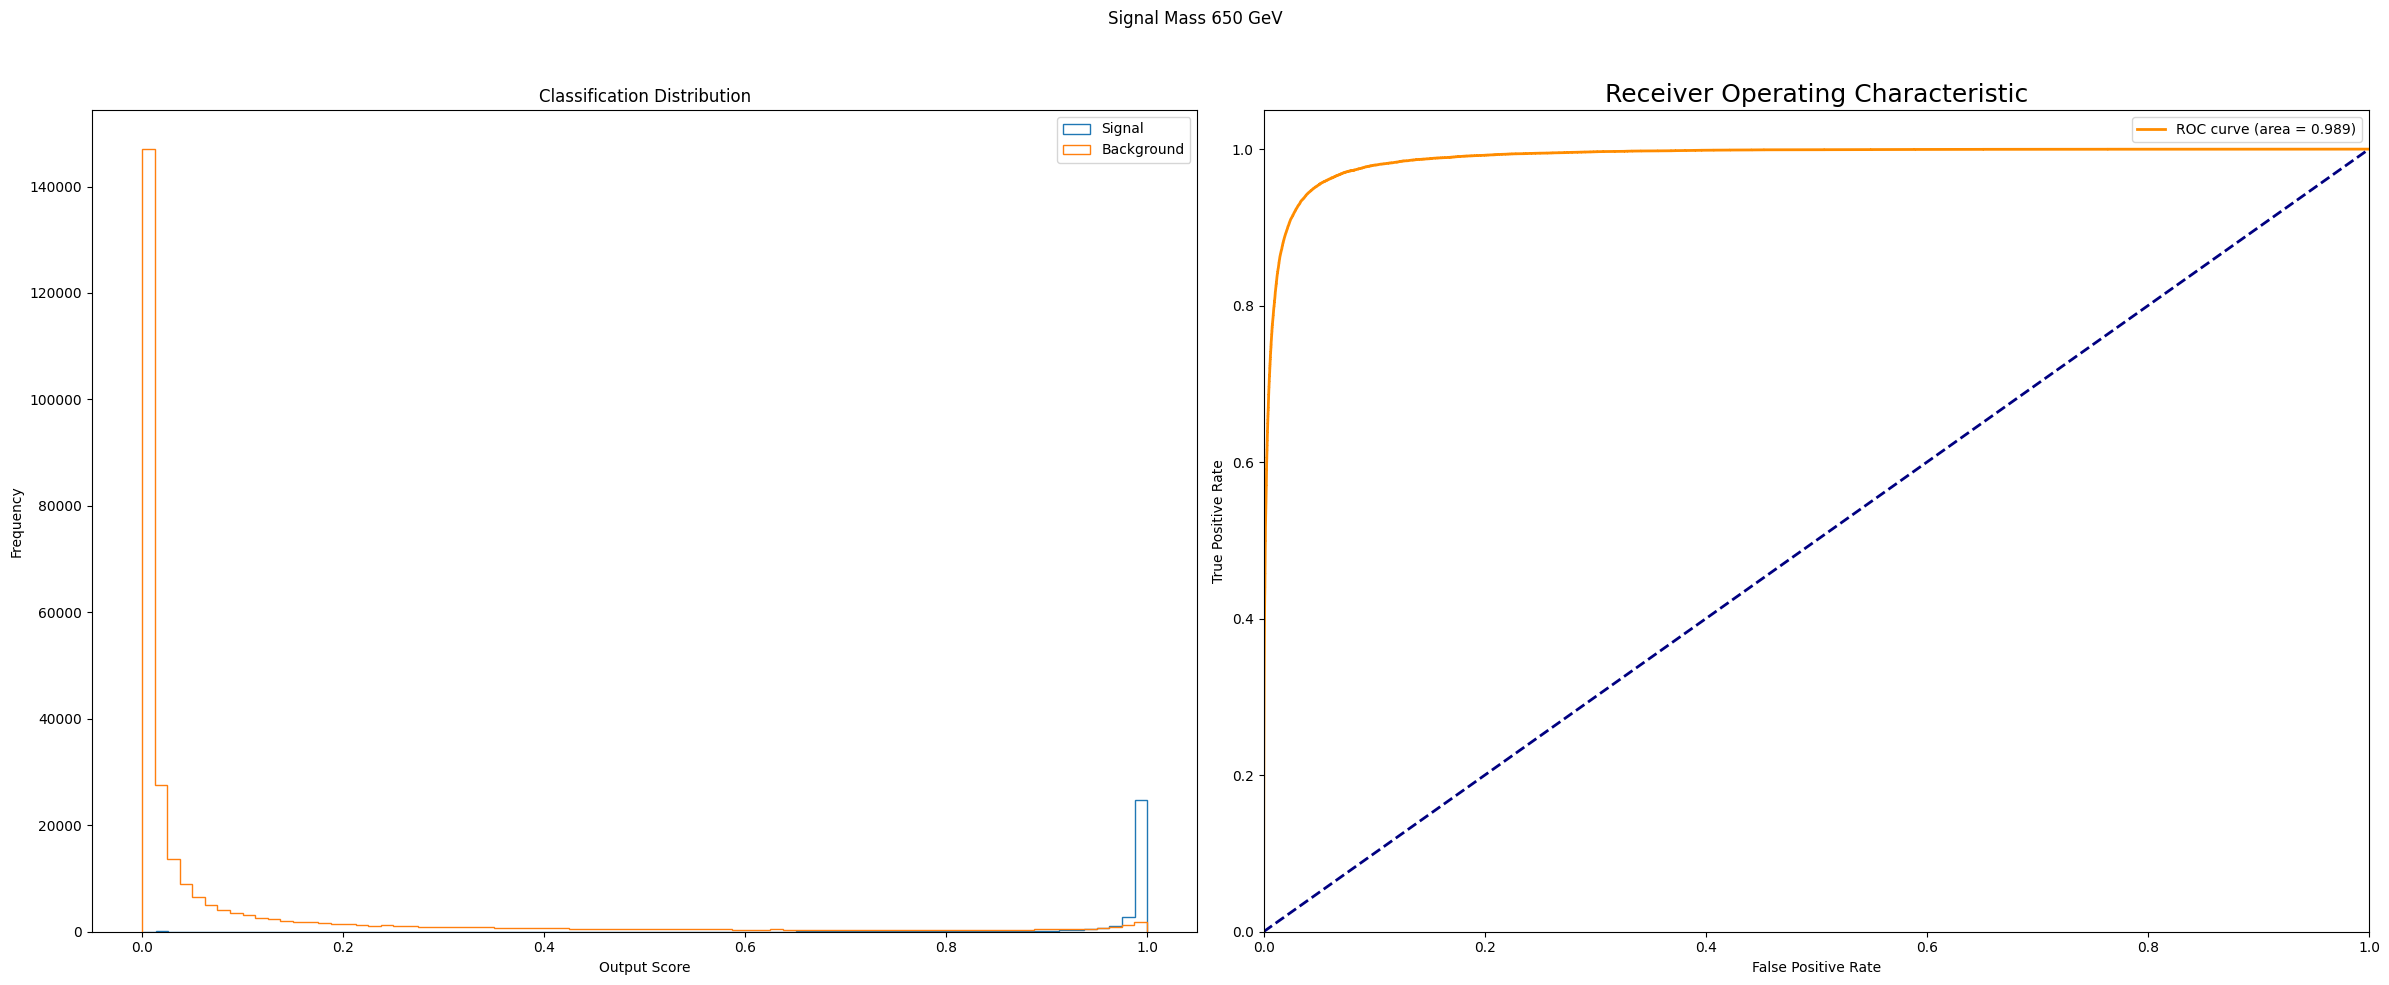

>> Saved output score in: output_score_signal_700.pkl ...


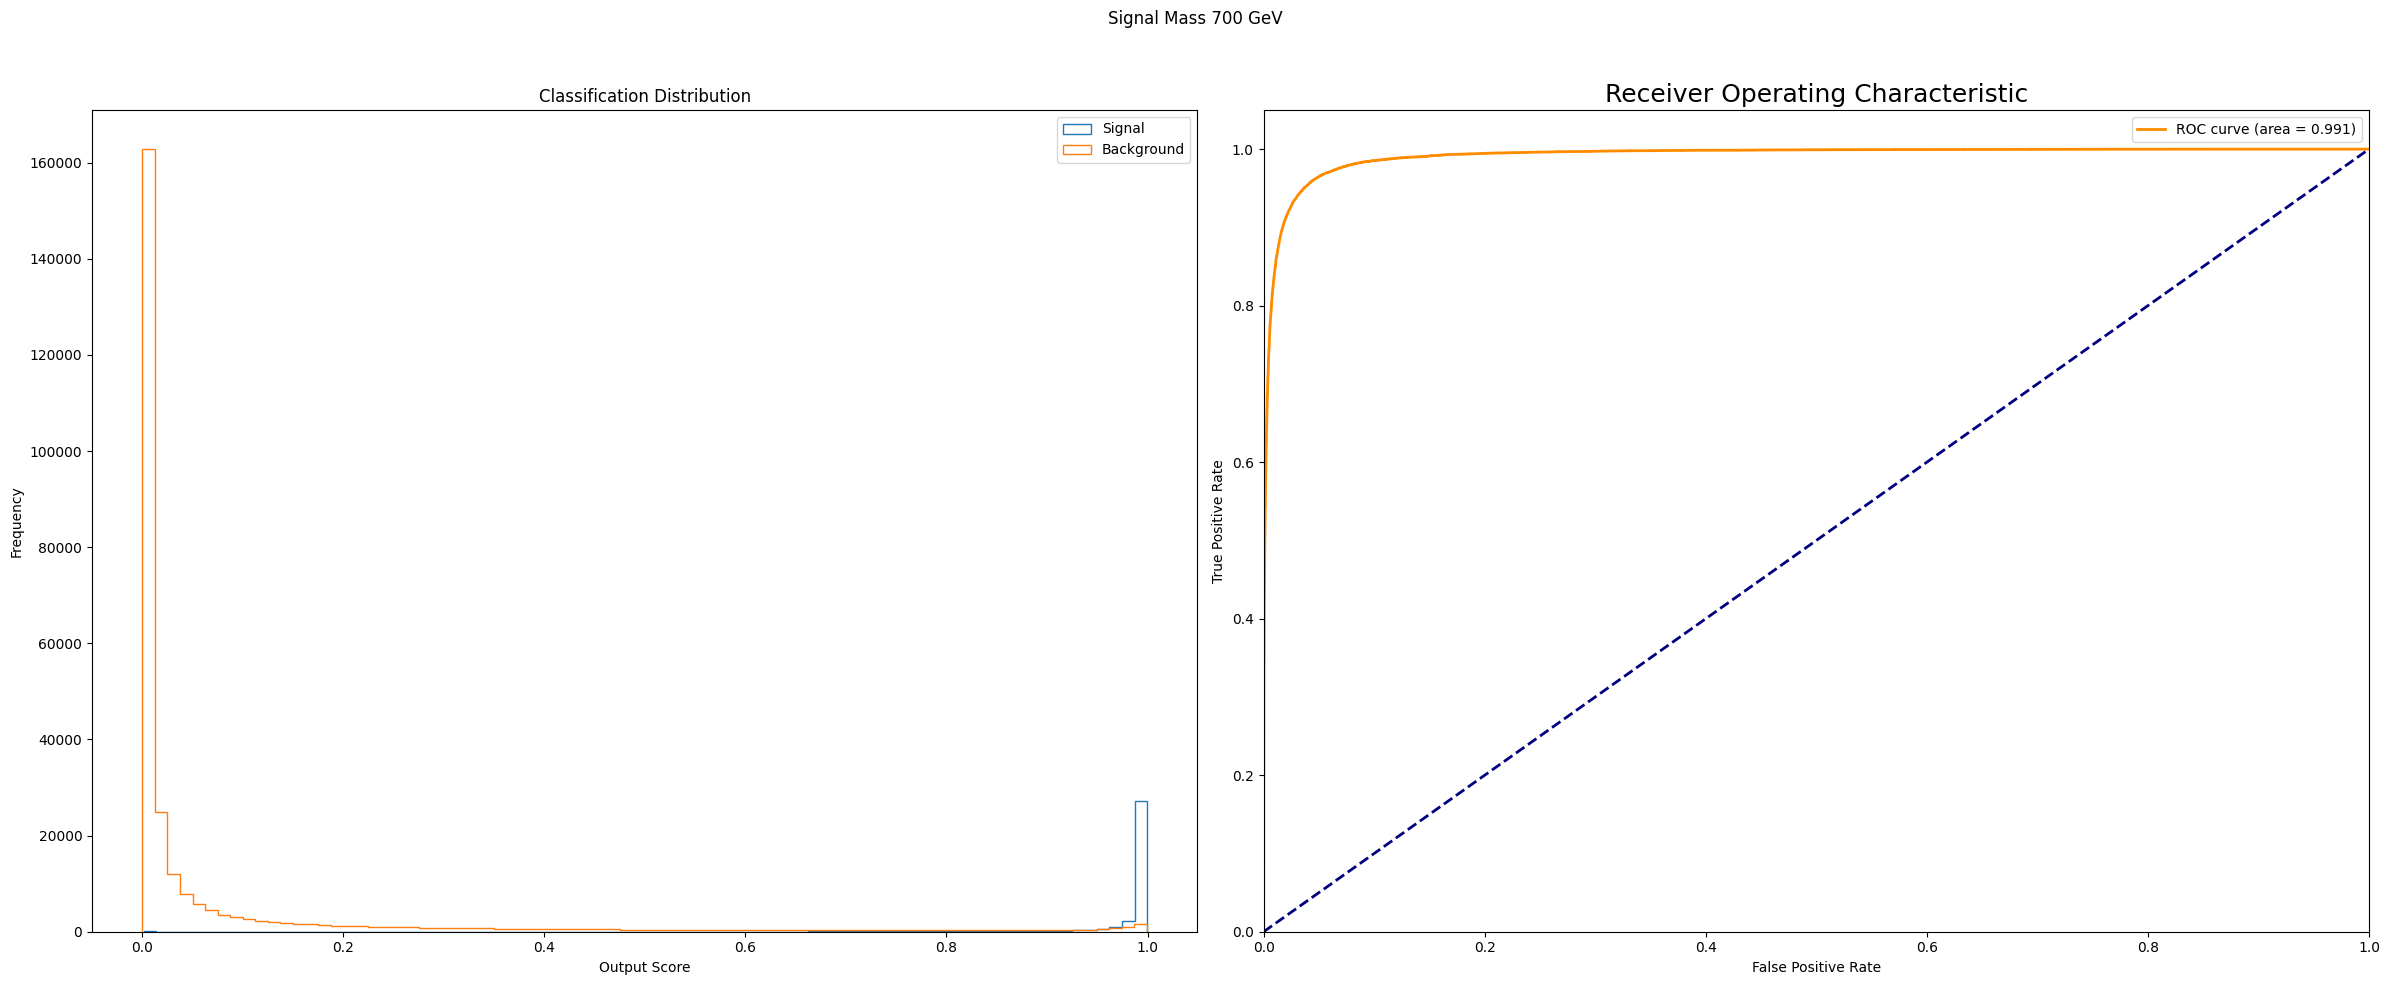

>> Saved output score in: output_score_signal_750.pkl ...


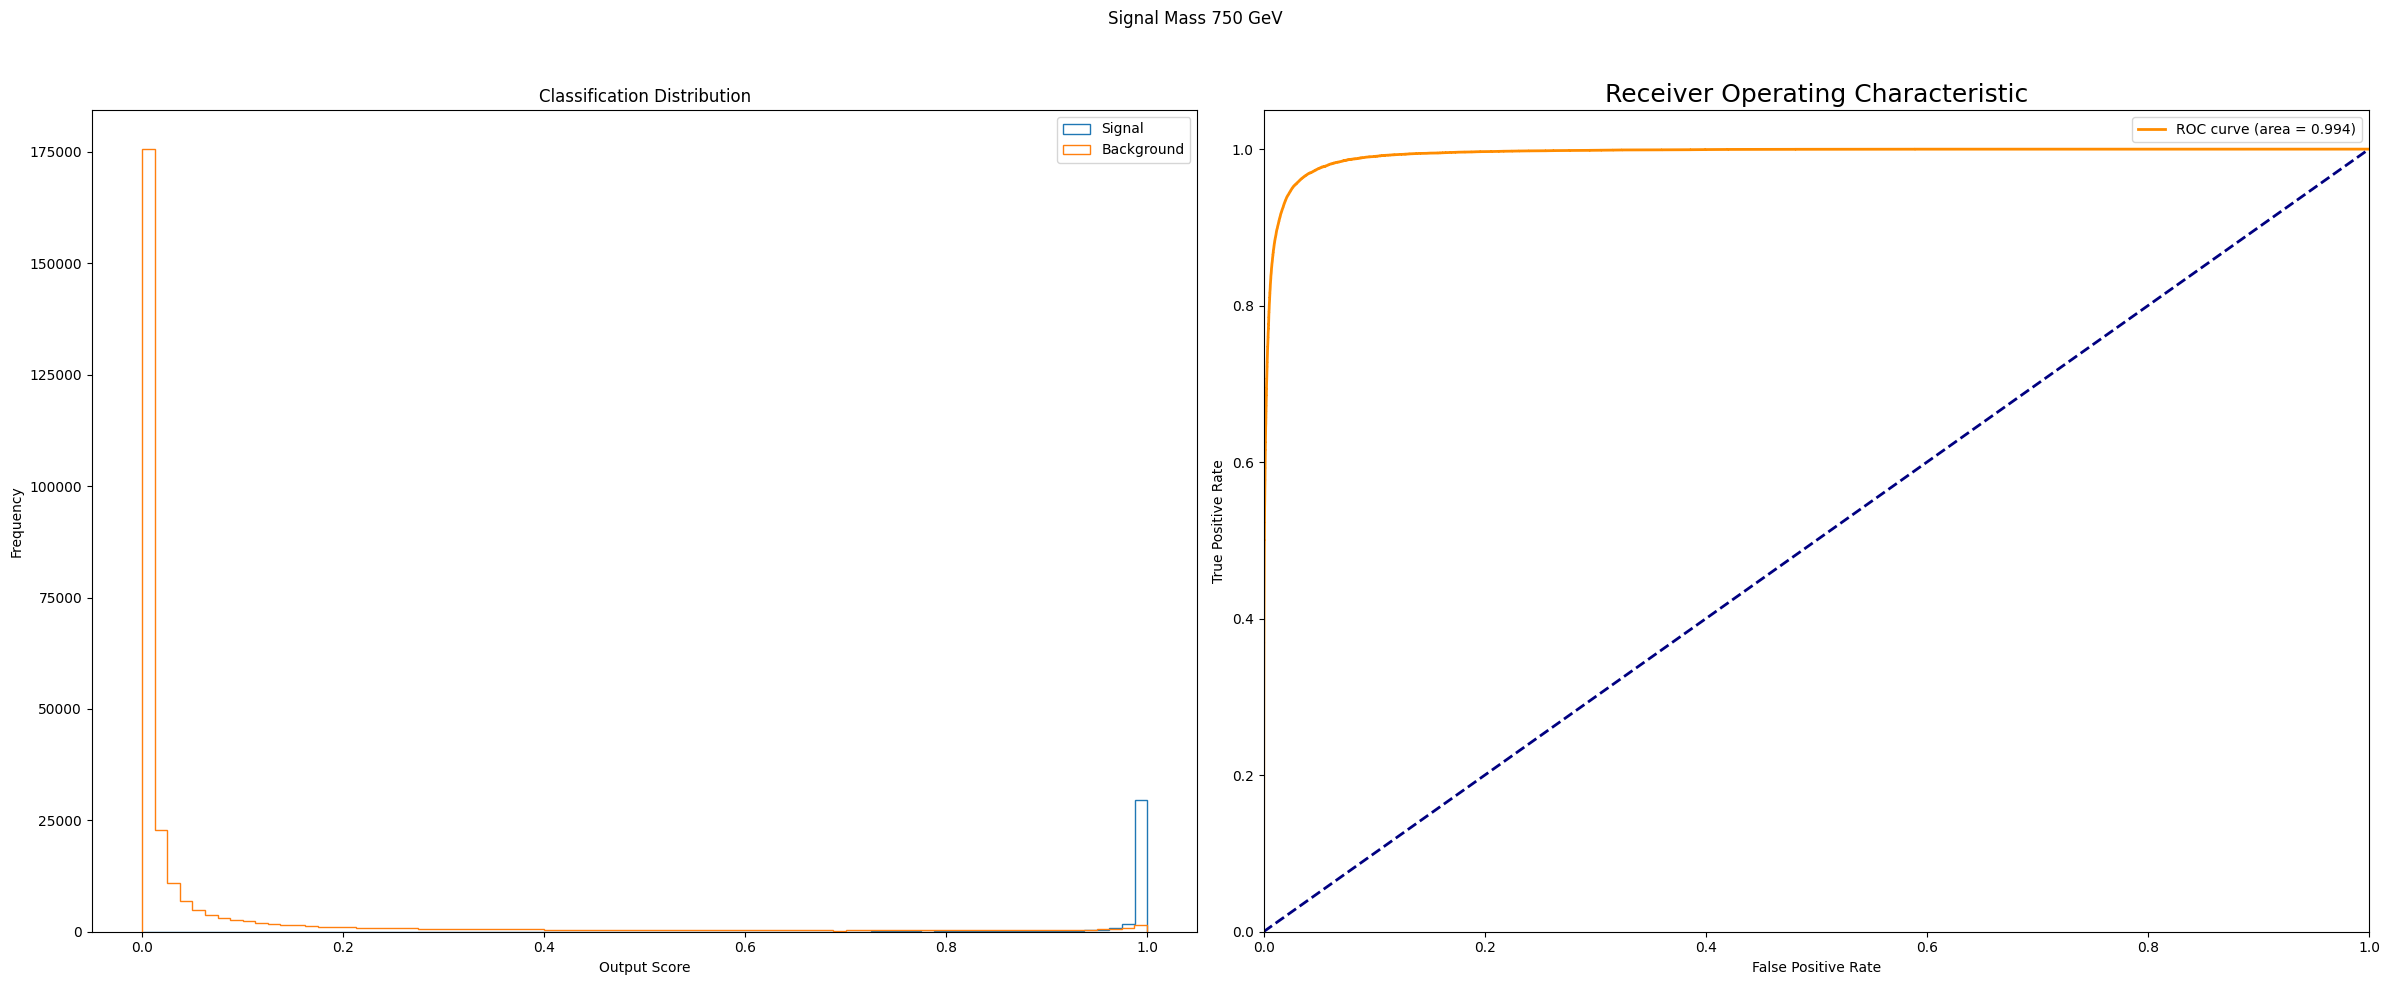

>> Saved output score in: output_score_signal_800.pkl ...


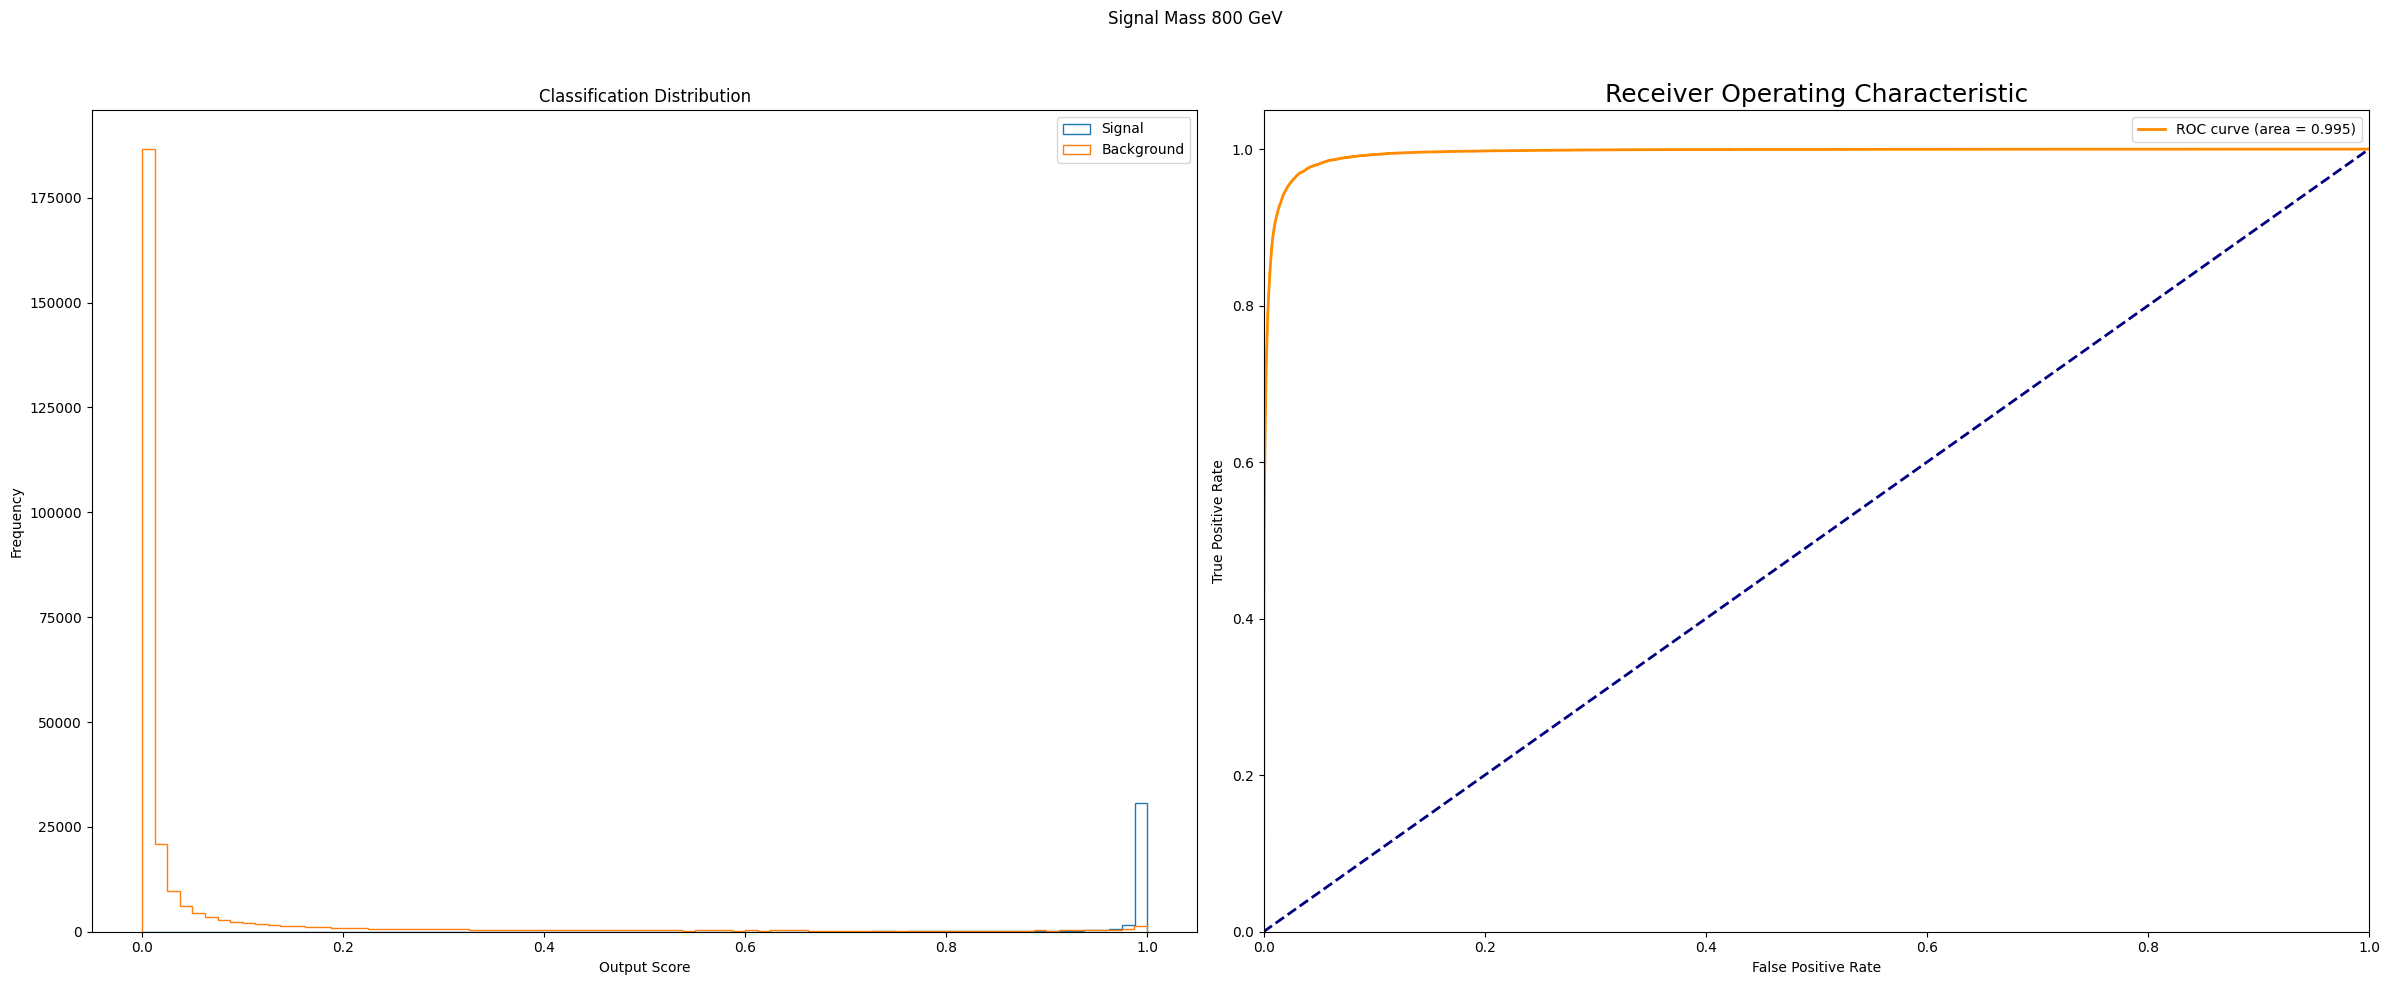

>> Saved output score in: output_score_signal_900.pkl ...


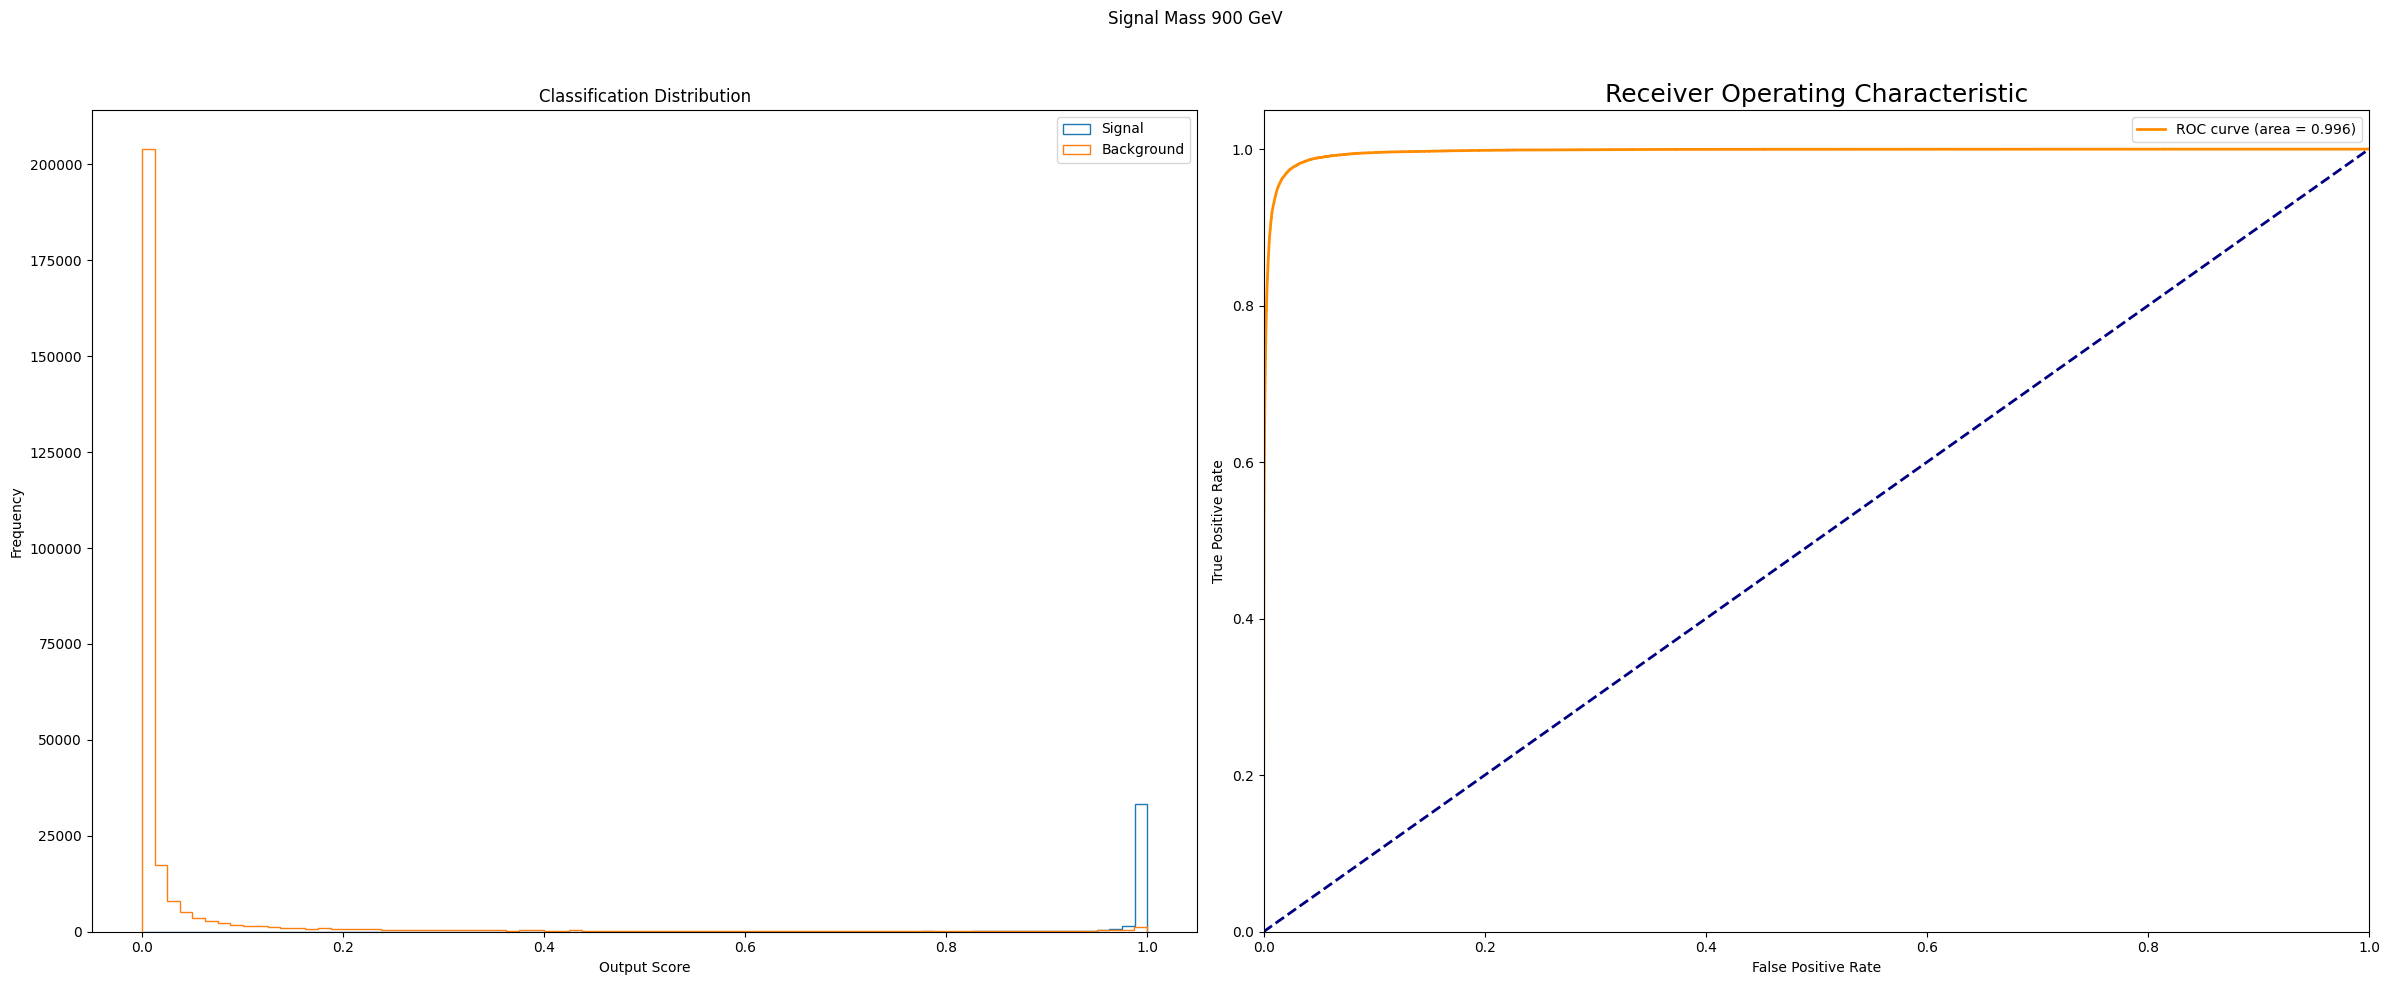

>> Saved output score in: output_score_signal_1000.pkl ...


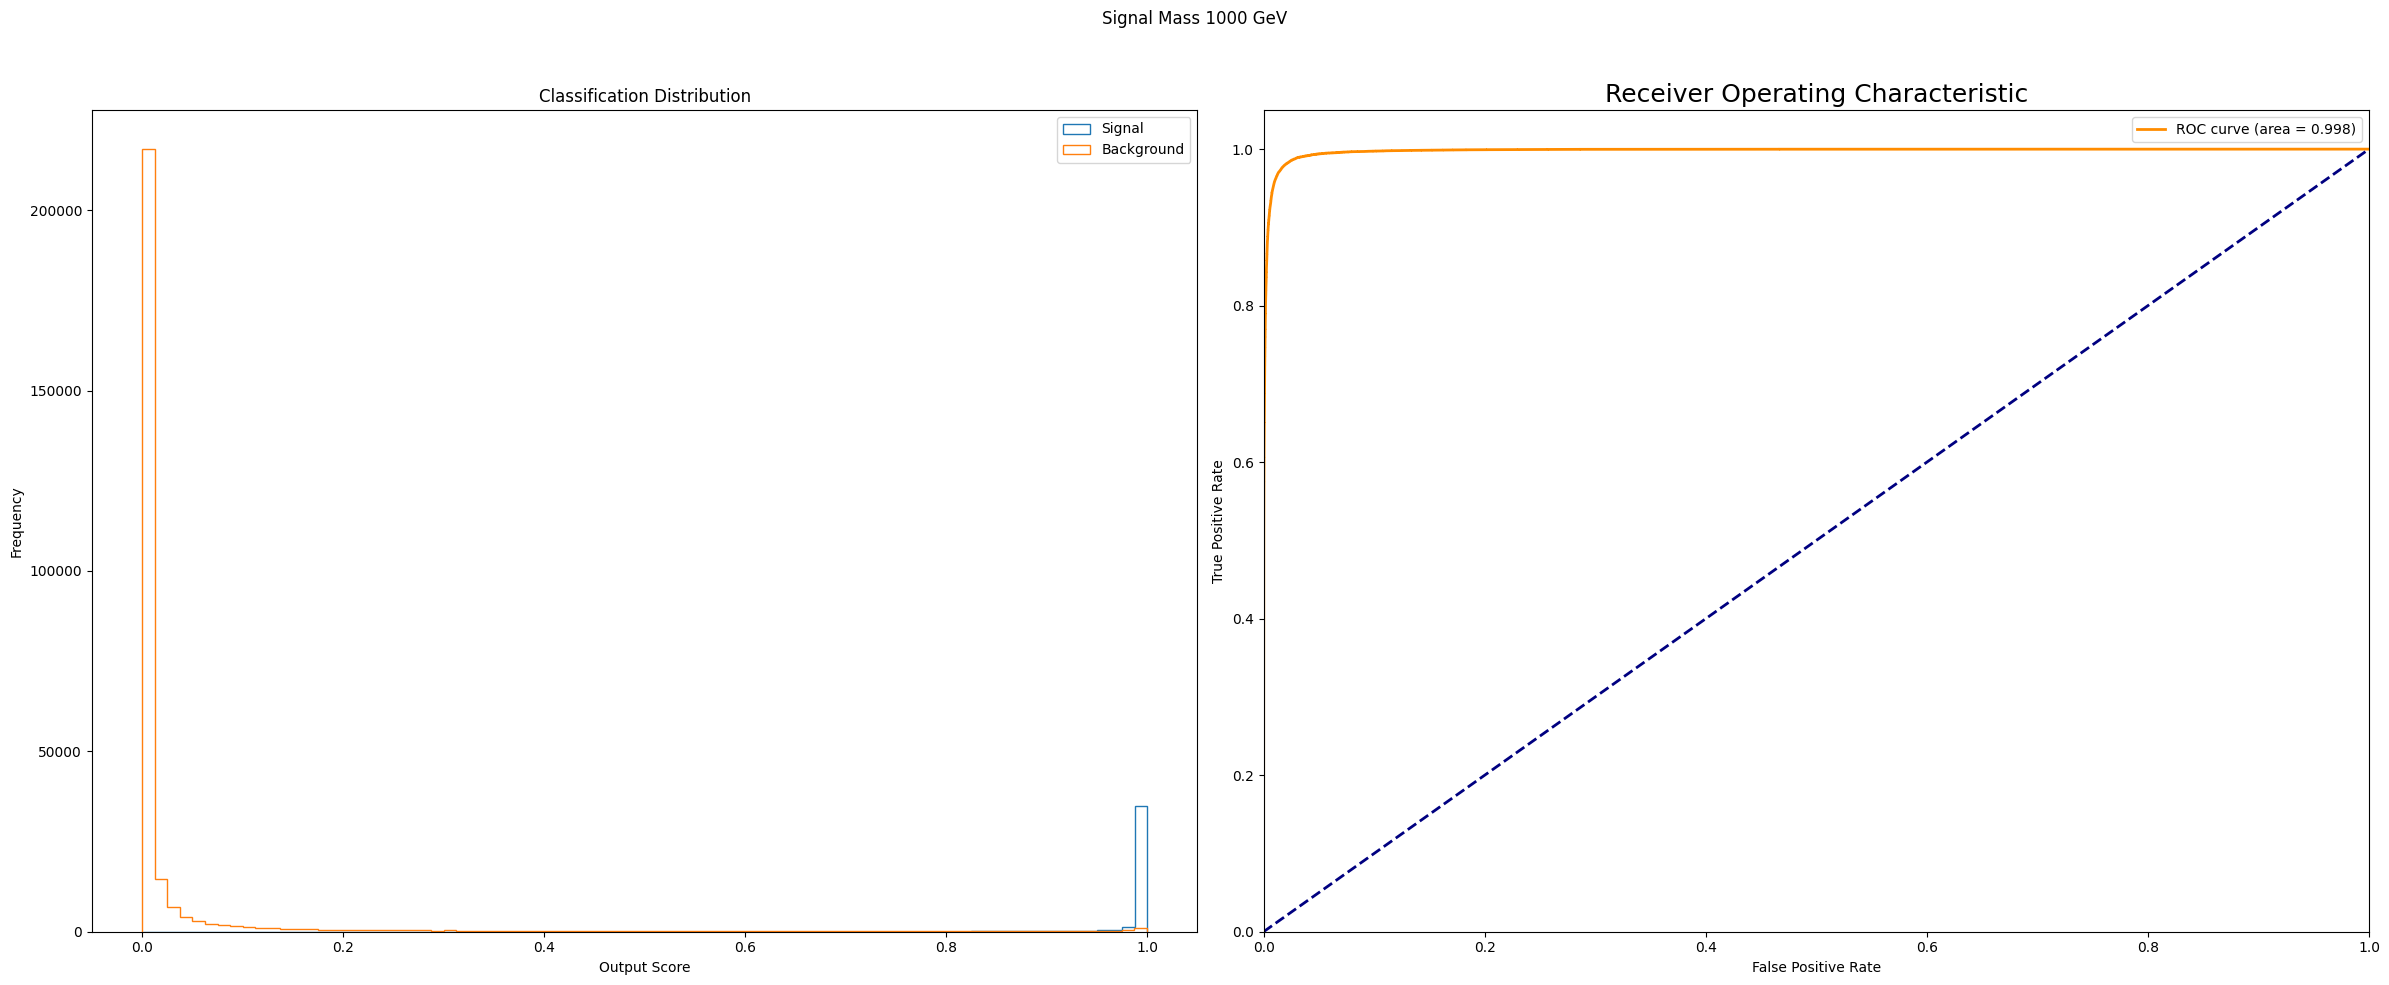

In [10]:
'''
SIMPLY RUN THIS CELL, YOU SHOULDN'T NEED TO CHANGE ANYTHING.
'''
def separate_output_score(output_score,y):
    dict_ = {'pred':output_score.cpu().detach().numpy().flatten(),'true':y}
    temp_df = pd.DataFrame(dict_)
    signal_output_score = temp_df.loc[temp_df['true'] == 1]['pred']
    background_output_score = temp_df.loc[temp_df['true'] == 0]['pred']
    return signal_output_score,background_output_score

print(f'>> All graphs and output score data will be saved in: {directory} ...')
allmasses=['260','270','280','290','300','320','350','400','450','500','550','600','650','700','750','800','900','1000']

model_auc = {}

for mass_eval in allmasses:

    signal_mass = int(mass_eval)
    
    x_test_global_signal = x_test_unscaled[x_test_unscaled['y'] == 1]
    x_test_global_background = x_test_unscaled[x_test_unscaled['y'] == 0]
    
    filtered_df_signal = x_test_global_signal[x_test_global_signal['MX'] == signal_mass]
    x_test_global_background.loc[:, 'MX'] = signal_mass
    combine_test_data = pd.concat([filtered_df_signal,x_test_global_background])
    test_df = combine_test_data.sample(frac=1,random_state = 42).reset_index(drop=True)
    
    test_df[feature_list] = scaler.transform(test_df[feature_list])
    
    X_test = test_df[feature_list].to_numpy()

    
    model.eval()
    with torch.no_grad():
        output_score_testing_individual = model(torch.Tensor(X_test).to(device))

    signal_testing_info = {
        'output_score':output_score_testing_individual,
        'y': test_df['y'],
        'weight_central': test_df['weight_central']
    }

    with open(f'{directory}/output_score_signal_{signal_mass}.pkl', 'wb') as f:
            pickle.dump(signal_testing_info, f)
    print(f'>> Saved output score in: output_score_signal_{signal_mass}.pkl ...')
    
    signal_output_score_test,background_output_score_test = separate_output_score(output_score_testing_individual,test_df['y'])
    
    fpr, tpr, thresholds = roc_curve(test_df['y'], output_score_testing_individual.cpu().detach().numpy())
    roc_auc = auc(fpr, tpr)
    
    fig, axs = plt.subplots(1, 2, figsize=(24, 10))
            
        
    # ax1_twin.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))
    
    axs[0].hist(signal_output_score_test, label = 'Signal',bins=80,histtype='step')
    axs[0].hist(background_output_score_test, label = 'Background',bins=80,histtype='step')
    axs[0].set_xlabel("Output Score")
    axs[0].set_title('Classification Distribution')
    axs[0].set_ylabel("Frequency")
    axs[0].legend()
    
    axs[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title('Receiver Operating Characteristic',fontsize=18)
    axs[1].legend(loc="lower right")
    plt.tight_layout()
    plt.legend()
    plt.savefig(f'{directory}/test_{str(signal_mass)}_graph.pdf',format = 'pdf')
    fig.suptitle(f'Signal Mass {str(signal_mass)} GeV')
    fig.subplots_adjust(top=0.88)
    plt.savefig(f'{directory}/test_{str(signal_mass)}_graph.png',format = 'png')
    plt.show()

    model_auc[signal_mass] = roc_auc


with open(f'{directory}/Single_mass_feature_{num_of_features}_auc.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, model_auc.keys())
    w.writeheader()
    w.writerow(model_auc)

# --------------------------------------------------------------------------------
# Plot each signal mass vs AUC score 

In [11]:
# Add the path of the auc file
feature_27_base = pd.read_csv(f'models_27_features_[50, 50, 50]/Single_mass_feature_27_auc.csv')
feature_27_high_batch = pd.read_csv(f'models_27_features_[50, 50, 50]_batch_size_131072/Single_mass_feature_27_auc.csv')
feature_27_dynamic_batch = pd.read_csv(f'models_27_features_[50, 50, 50]_dynamic_batch_size/Single_mass_feature_27_auc.csv')
feature_27_dynamic_batch_scheduler = pd.read_csv(f'models_27_features_[50, 50, 50]_dynamic_batch_size+scheduler/Single_mass_feature_27_auc.csv')
feature_27_scheduler_50_100_100_50 = pd.read_csv(f'models_27_features_[50, 100, 100, 50]/Single_mass_feature_27_auc.csv')

# add the file into the dictionary, the key will be the label for the graph
plotting = {
    'Scheduler only pNN, node: [50, 50, 50] (Union of 27 Features)': feature_27_base,
    'High Batch pNN, node: [50, 50, 50] (Union of 27 Features)': feature_27_high_batch,
    'Dynamic Batch pNN, node: [50, 50, 50] (Union of 27 Features)': feature_27_dynamic_batch,
    'Dynamic Batch pNN + Scheduler, node: [50, 50, 50] (Union of 27 Features)': feature_27_dynamic_batch_scheduler,
    'Scheduler only pNN, node: [50, 100, 100, 50] (Union of 27 Features)': feature_27_scheduler_50_100_100_50
}

>> Directory exists ...
>> pNN_Graphs/pNN_Comparison.png saved...
>> pNN_Graphs/pNN_Comparison.pdf saved...


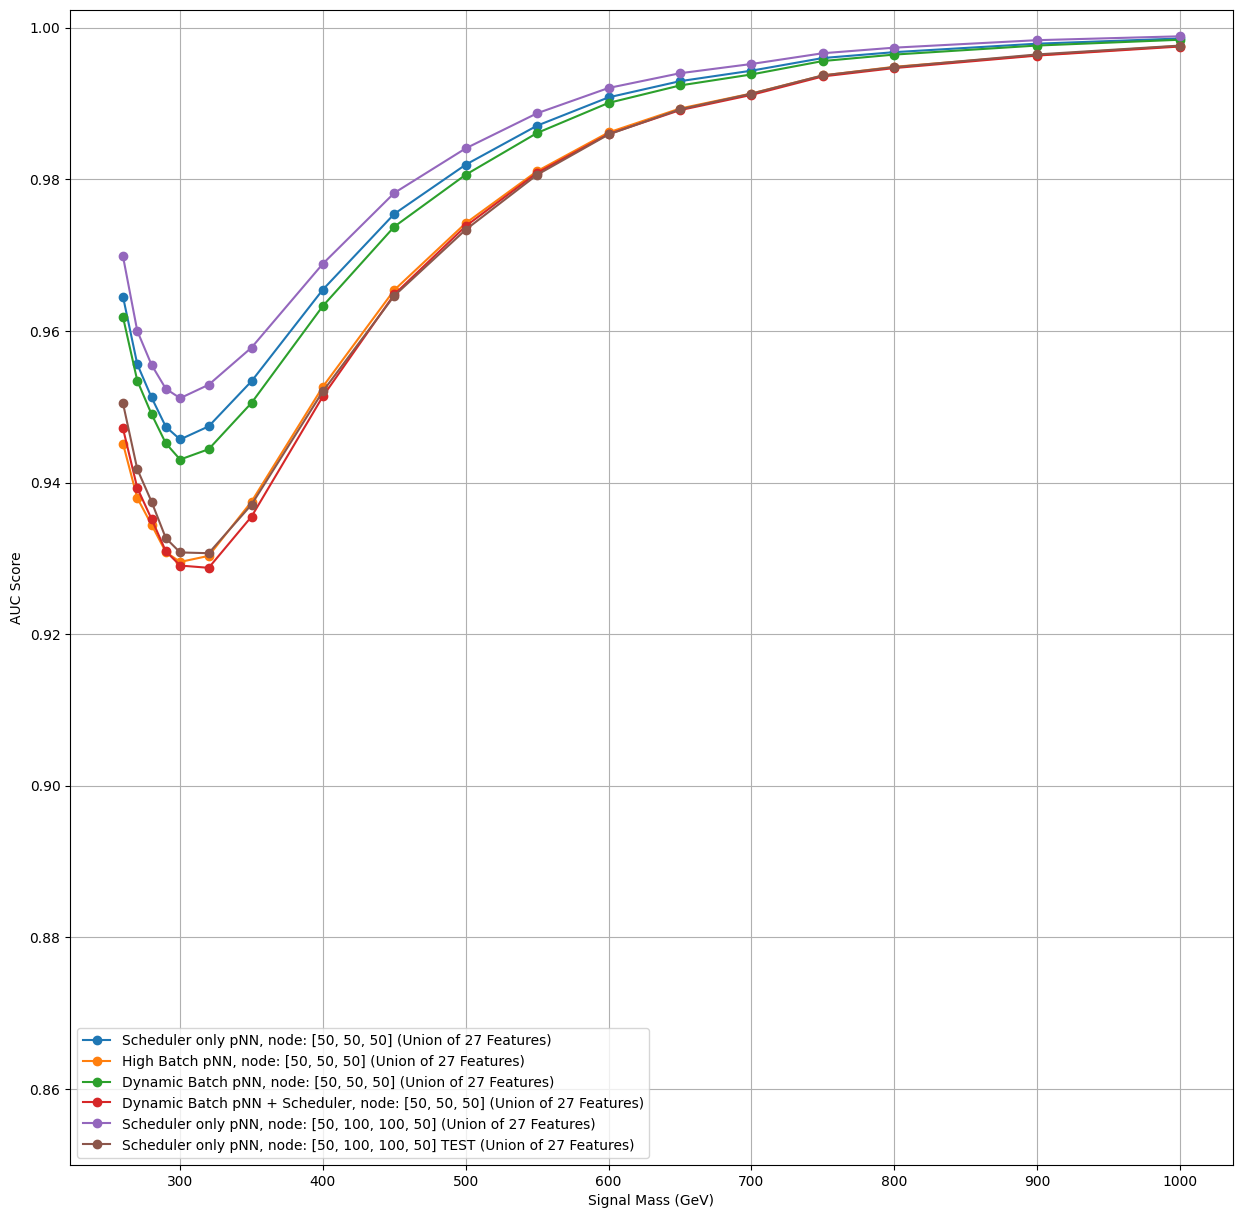

In [12]:
# Update these variables below
file_name_of_graph = 'pNN_Comparison'
directory_for_graph = 'pNN_Graphs'


#Nothing below needs to be changed, please only update cell above.
if not os.path.exists(directory_for_graph):
    # Create the directory
    os.makedirs(directory_for_graph)
    print(">> Directory created successfully ...")
else:
    print(">> Directory exists ...")

allmasses=['260','270','280','290','300','320','350','400','450','500','550','600','650','700','750','800','900','1000']
int_masses = [int(i) for i in allmasses]
plt.figure(figsize=(15,15))
for key, value in plotting.items():
    roc_auc = []
    for key_plot in value.keys():
        roc_auc.append(value[key_plot].item())
    plt.plot(int_masses,roc_auc, marker = 'o',label = key)
plt.xlabel('Signal Mass (GeV)')
plt.ylabel('AUC Score')
plt.ylim(bottom = 0.85)
plt.legend()
plt.grid()
plt.savefig(f'{directory_for_graph}/{file_name_of_graph}.png',format = 'png')
plt.savefig(f'{directory_for_graph}/{file_name_of_graph}.pdf',format = 'pdf')
print(f">> {directory_for_graph}/{file_name_of_graph}.png saved...")
print(f">> {directory_for_graph}/{file_name_of_graph}.pdf saved...")
plt.show()
    